In [969]:
# packages_to_have <- c('cowplot', 'reticulate', 'tidyverse', 'igraph', 'r2r', 'formattable', 'stringr', 'viridis', 'geomtextpath')

# dir.create(Sys.getenv("R_LIBS_USER"), recursive = TRUE)  # create personal library
# .libPaths(Sys.getenv("R_LIBS_USER"))  # add to the path

# packages = installed.packages()
# packages = packages[, "Package"]

# if (FALSE %in% (packages_to_have %in% packages)){
#     install.packages(packages_to_have)
# }

Sys.setenv(VROOM_TEMP_PATH = './vroom')
system("mkdir -p ./vroom")
system("rm ./vroom/*")

# To call python from R
library(IRdisplay)

library(archive)
library(dplyr)
library(reticulate)
library(tidyverse)
library(igraph)
library(r2r)
library(formattable)
library(stringr)
library(viridis)
library(geomtextpath)
library(cowplot)
library(scales)
library(vroom)
library(zoo)
library(ggdist)
library(gghighlight)
library(ggrepel)
library(ggbreak)
library(grid)
library(lemon)
library(ggprism)
library(ggh4x)
library(ggExtra)
library(tibbletime)
library(snakecase)
library(foreach)
library(doParallel)
library(ggside)
library(ggbeeswarm)
library(multidplyr)
library(ggpubr)
library(Hmisc)
library(rstatix)
library(multcompView)
# library(gifski)
library(gganimate)

library(intergraph)
library(network)
library(ggnetwork)

library(purrr)
library(future.apply)
future::plan("multicore", workers = 20L)

theme_set(theme_prism())


In [242]:
fig <- function(width, heigth) {
  options(repr.plot.width = width, repr.plot.height = heigth)
}

center_reduction <- function(data, colvar) {
    colvar <- rlang::sym(colvar)
    data %>%
        inner_join(data %>% summarise(mean = mean(!!colvar), sd = sd(!!colvar))) %>%
        mutate(!!colvar := (!!colvar - mean)/sd) %>%
        select(-c("sd", "mean"))
}

In [243]:
# All this is implemented (plus bugfixes!) in the ggnewscale package:
# https://github.com/eliocamp/ggnewscale
# If you have any issues, I prefer it if you send them as issues here:
# https://github.com/eliocamp/ggnewscale/issues

#' Allows to add another scale
#'
#' @param new_aes character with the aesthetic for which new scales will be
#' created
#'
new_scale <- function(new_aes) {
  structure(ggplot2::standardise_aes_names(new_aes), class = "new_aes")
}

#' Convenient functions
new_scale_fill <- function() {
  new_scale("fill")
}

new_scale_color <- function() {
  new_scale("colour")
}

new_scale_colour <- function() {
  new_scale("colour")
}

new_scale_alpha <- function() {
  new_scale("alpha")
}

new_scale_y <- function() {
  new_scale("y")
}

#' Special behaviour of the "+" for adding a `new_aes` object
#' It changes the name of the aesthethic for the previous layers, appending
#' "_new" to them.
ggplot_add.new_aes <- function(object, plot, object_name) {
  plot$layers <- lapply(plot$layers, bump_aes, new_aes = object)
  plot$scales$scales <- lapply(plot$scales$scales, bump_aes, new_aes = object)
  plot$labels <- bump_aes(plot$labels, new_aes = object)
  plot
}


bump_aes <- function(layer, new_aes) {
  UseMethod("bump_aes")
}

bump_aes.Scale <- function(layer, new_aes) {
  old_aes <- layer$aesthetics[remove_new(layer$aesthetics) %in% new_aes]
  new_aes <- paste0(old_aes, "_new")

  layer$aesthetics[layer$aesthetics %in% old_aes] <- new_aes

  if (is.character(layer$guide)) {
    layer$guide <- match.fun(paste("guide_", layer$guide, sep = ""))()
  }
  layer$guide$available_aes[layer$guide$available_aes %in% old_aes] <- new_aes
  layer
}

bump_aes.Layer <- function(layer, new_aes) {
  original_aes <- new_aes

  old_aes <- names(layer$mapping)[remove_new(names(layer$mapping)) %in% new_aes]
  new_aes <- paste0(old_aes, "_new")

  old_geom <- layer$geom

  old_setup <- old_geom$handle_na
  new_setup <- function(self, data, params) {
    colnames(data)[colnames(data) %in% new_aes] <- original_aes
    old_setup(data, params)
  }

  new_geom <- ggplot2::ggproto(paste0("New", class(old_geom)[1]), old_geom,
    handle_na = new_setup
  )

  new_geom$default_aes <- change_name(new_geom$default_aes, old_aes, new_aes)
  new_geom$non_missing_aes <- change_name(new_geom$non_missing_aes, old_aes, new_aes)
  new_geom$required_aes <- change_name(new_geom$required_aes, old_aes, new_aes)
  new_geom$optional_aes <- change_name(new_geom$optional_aes, old_aes, new_aes)

  layer$geom <- new_geom

  old_stat <- layer$stat

  old_setup2 <- old_stat$handle_na
  new_setup <- function(self, data, params) {
    colnames(data)[colnames(data) %in% new_aes] <- original_aes
    old_setup2(data, params)
  }

  new_stat <- ggplot2::ggproto(paste0("New", class(old_stat)[1]), old_stat,
    handle_na = new_setup
  )

  new_stat$default_aes <- change_name(new_stat$default_aes, old_aes, new_aes)
  new_stat$non_missing_aes <- change_name(new_stat$non_missing_aes, old_aes, new_aes)
  new_stat$required_aes <- change_name(new_stat$required_aes, old_aes, new_aes)
  new_stat$optional_aes <- change_name(new_stat$optional_aes, old_aes, new_aes)

  layer$stat <- new_stat

  layer$mapping <- change_name(layer$mapping, old_aes, new_aes)
  layer
}

bump_aes.list <- function(layer, new_aes) {
  old_aes <- names(layer)[remove_new(names(layer)) %in% new_aes]
  new_aes <- paste0(old_aes, "_new")

  names(layer)[names(layer) %in% old_aes] <- new_aes
  layer
}

change_name <- function(list, old, new) {
  UseMethod("change_name")
}

change_name.character <- function(list, old, new) {
  list[list %in% old] <- new
  list
}

change_name.default <- function(list, old, new) {
  nam <- names(list)
  nam[nam %in% old] <- new
  names(list) <- nam
  list
}

change_name.NULL <- function(list, old, new) {
  NULL
}

remove_new <- function(aes) {
  stringi::stri_replace_all(aes, "", regex = "(_new)*")
}


# Experiment

## Perequisites

Extract the data to `./metrics`

## Preparations

Import necessary libraries

Idées de mesures:

- distribution des fonctions
- politique basique edge first ou quoi
- temps de deploiement vs nombre de noeuds dans le Fog vs taille du réseau
- temps de deploiement vs nombre de fonctions vs taille du réseau
- la mémoire et le cpu au niveau du noeud fog

graohes des localités : courbe qui montre combien de fonctions se répartissent sur l'edge et sur le cloud
faire varier le nombre de noeuds

Changer le nombre de fonctions que l'on déploi = saturation (x nbre de fonction)
Regarder l'évolution des temps de réponses / des violations de temps de deadline

Regarder si on satisfait les deadlines et si c'est scalable

Comparer en terme de prix = pas relevant
Définir une fonction d'utilité au niveau des enchères, par rapport au temps d'exécution




In [942]:
generate_gif <- FALSE
reload_big_data <- TRUE
parallel_loading_datasets <- 2
parallel_loading_datasets_small <- 22

GRAPH_ONE_COLUMN_HEIGHT <- 3
GRAPH_ONE_COLUMN_WIDTH <- 5
GRAPH_HALF_COLUMN_WIDTH <- 2.5
GRAPH_TWO_COLUMN_WIDTH <- 12

METRICS_PATH <- "metrics-arks"
METRICS_ARKS <- c(
    # "metrics_valuation_rates.env_DEV-auction_valuation_rates_no-telemetry_2023-09-21-18-57.tar.xz",
    # "metrics_valuation_rates.env_DEV-edge_first_v2_valuation_rates_no-telemetry_2023-09-21-20-15.tar.xz",
    # "metrics_valuation_rates.env_10-auction_valuation_rates_no-telemetry_2023-09-10-05-28.tar.xz",
    # "metrics_valuation_rates.env_10-edge_first_v2_valuation_rates_no-telemetry_2023-09-10-04-48.tar.xz",
    # "metrics_valuation_rates.env_11-auction_valuation_rates_no-telemetry_2023-09-10-06-08.tar.xz",
    # "metrics_valuation_rates.env_11-edge_first_v2_valuation_rates_no-telemetry_2023-09-10-07-34.tar.xz",
    # "metrics_valuation_rates.env_11-edge_ward_valuation_rates_no-telemetry_2023-09-10-06-50.tar.xz",
    # "metrics_valuation_rates.env_12-edge_first_v2_valuation_rates_no-telemetry_2023-09-10-08-29.tar.xz",
    # "metrics_valuation_rates.env_12-edge_ward_valuation_rates_no-telemetry_2023-09-10-09-11.tar.xz",
    # "metrics_valuation_rates.env_13-edge_first_v2_valuation_rates_no-telemetry_2023-09-10-10-53.tar.xz",
    # "metrics_valuation_rates.env_13-edge_ward_valuation_rates_no-telemetry_2023-09-10-09-58.tar.xz",
    # "metrics_valuation_rates.env_14-auction_valuation_rates_no-telemetry_2023-09-10-13-32.tar.xz",
    # "metrics_valuation_rates.env_15-edge_first_v2_valuation_rates_no-telemetry_2023-09-10-15-25.tar.xz",
    # "metrics_valuation_rates.env_15-edge_ward_valuation_rates_no-telemetry_2023-09-10-14-15.tar.xz",
    # "metrics_valuation_rates.env_16-edge_ward_valuation_rates_no-telemetry_2023-09-10-16-41.tar.xz",
    # "metrics_valuation_rates.env_1-auction_valuation_rates_no-telemetry_2023-09-09-20-38.tar.xz",
    # "metrics_valuation_rates.env_1-edge_first_v2_valuation_rates_no-telemetry_2023-09-09-19-58.tar.xz",
    # "metrics_valuation_rates.env_1-edge_ward_valuation_rates_no-telemetry_2023-09-09-21-18.tar.xz",
    # "metrics_valuation_rates.env_2-edge_first_v2_valuation_rates_no-telemetry_2023-09-09-20-21.tar.xz",
    # "metrics_valuation_rates.env_2-edge_ward_valuation_rates_no-telemetry_2023-09-09-21-02.tar.xz",
    # "metrics_valuation_rates.env_4-auction_valuation_rates_no-telemetry_2023-09-09-21-48.tar.xz",
    # "metrics_valuation_rates.env_4-edge_first_v2_valuation_rates_no-telemetry_2023-09-09-23-37.tar.xz",
    # "metrics_valuation_rates.env_4-edge_ward_valuation_rates_no-telemetry_2023-09-09-22-42.tar.xz",
    # "metrics_valuation_rates.env_5-auction_valuation_rates_no-telemetry_2023-09-09-22-02.tar.xz",
    # "metrics_valuation_rates.env_5-edge_first_v2_valuation_rates_no-telemetry_2023-09-09-22-53.tar.xz",
    # "metrics_valuation_rates.env_5-edge_ward_valuation_rates_no-telemetry_2023-09-09-23-42.tar.xz",
    # "metrics_valuation_rates.env_6-auction_valuation_rates_no-telemetry_2023-09-10-01-45.tar.xz",
    # "metrics_valuation_rates.env_6-edge_first_v2_valuation_rates_no-telemetry_2023-09-10-00-18.tar.xz",
    # "metrics_valuation_rates.env_6-edge_ward_valuation_rates_no-telemetry_2023-09-10-01-00.tar.xz",
    # "metrics_valuation_rates.env_7-edge_first_v2_valuation_rates_no-telemetry_2023-09-10-02-35.tar.xz",
    # "metrics_valuation_rates.env_7-edge_ward_valuation_rates_no-telemetry_2023-09-10-00-36.tar.xz",
    # "metrics_valuation_rates.env_8-edge_ward_valuation_rates_no-telemetry_2023-09-10-03-19.tar.xz",

    # "metrics_valuation_rates.env_1-auction_valuation_rates_no-telemetry_2023-09-22-09-52.tar.xz",
    # "metrics_valuation_rates.env_1-edge_first_v2_valuation_rates_no-telemetry_2023-09-22-10-20.tar.xz",

    # "metrics_valuation_rates.env_1-auction_valuation_rates_no-telemetry_2023-09-22-13-30.tar.xz",
    # "metrics_valuation_rates.env_1-auction_valuation_rates_no-telemetry_2023-09-22-16-58.tar.xz",
    # "metrics_valuation_rates.env_1-edge_ward_valuation_rates_no-telemetry_2023-09-22-13-03.tar.xz",


"metrics_valuation_rates.env_10-edge_first_v2_valuation_rates_no-telemetry_2023-09-22-23-30.tar.xz",
# "metrics_valuation_rates.env_10-edge_ward_valuation_rates_no-telemetry_2023-09-23-00-30.tar.xz",
"metrics_valuation_rates.env_11-auction_valuation_rates_no-telemetry_2023-09-23-00-27.tar.xz",

# "metrics_valuation_rates.env_11-edge_ward_valuation_rates_no-telemetry_2023-09-23-01-20.tar.xz",
"metrics_valuation_rates.env_12-edge_first_v2_valuation_rates_no-telemetry_2023-09-23-01-18.tar.xz",
"metrics_valuation_rates.env_12-edge_ward_valuation_rates_no-telemetry_2023-09-23-02-05.tar.xz",

"metrics_valuation_rates.env_1-auction_valuation_rates_no-telemetry_2023-09-22-19-38.tar.xz",
"metrics_valuation_rates.env_1-edge_first_v2_valuation_rates_no-telemetry_2023-09-22-18-59.tar.xz",
"metrics_valuation_rates.env_1-edge_ward_valuation_rates_no-telemetry_2023-09-22-20-18.tar.xz",
"metrics_valuation_rates.env_2-edge_first_v2_valuation_rates_no-telemetry_2023-09-22-20-06.tar.xz",
"metrics_valuation_rates.env_2-edge_ward_valuation_rates_no-telemetry_2023-09-22-18-59.tar.xz",
"metrics_valuation_rates.env_3-auction_valuation_rates_no-telemetry_2023-09-22-19-35.tar.xz",
"metrics_valuation_rates.env_3-edge_first_v2_valuation_rates_no-telemetry_2023-09-22-20-15.tar.xz",
"metrics_valuation_rates.env_3-edge_ward_valuation_rates_no-telemetry_2023-09-22-18-53.tar.xz",
"metrics_valuation_rates.env_4-auction_valuation_rates_no-telemetry_2023-09-23-11-12.tar.xz",
"metrics_valuation_rates.env_4-edge_first_v2_valuation_rates_no-telemetry_2023-09-23-11-59.tar.xz",
"metrics_valuation_rates.env_4-edge_ward_valuation_rates_no-telemetry_2023-09-23-12-42.tar.xz",

"metrics_valuation_rates.env_5-auction_valuation_rates_no-telemetry_2023-09-22-20-54.tar.xz",
"metrics_valuation_rates.env_5-edge_first_v2_valuation_rates_no-telemetry_2023-09-22-21-43.tar.xz",
"metrics_valuation_rates.env_5-edge_ward_valuation_rates_no-telemetry_2023-09-22-22-27.tar.xz",
"metrics_valuation_rates.env_6-edge_first_v2_valuation_rates_no-telemetry_2023-09-22-21-10.tar.xz",
"metrics_valuation_rates.env_6-edge_ward_valuation_rates_no-telemetry_2023-09-22-21-54.tar.xz",
"metrics_valuation_rates.env_7-edge_first_v2_valuation_rates_no-telemetry_2023-09-22-21-48.tar.xz",
"metrics_valuation_rates.env_7-edge_ward_valuation_rates_no-telemetry_2023-09-22-21-03.tar.xz",
"metrics_valuation_rates.env_8-auction_valuation_rates_no-telemetry_2023-09-22-22-45.tar.xz",
"metrics_valuation_rates.env_8-edge_first_v2_valuation_rates_no-telemetry_2023-09-22-23-29.tar.xz",
"metrics_valuation_rates.env_8-edge_ward_valuation_rates_no-telemetry_2023-09-23-00-09.tar.xz",
"metrics_valuation_rates.env_9-edge_first_v2_valuation_rates_no-telemetry_2023-09-22-23-38.tar.xz",
"metrics_valuation_rates.env_9-edge_ward_valuation_rates_no-telemetry_2023-09-22-22-54.tar.xz",
#---
#---
#---
"last element that is here because last element should not have any comma in the end and that sucks hard time."
)
METRICS_ARKS <- METRICS_ARKS[-length(METRICS_ARKS)]

METRICS_GROUP <- str_match(METRICS_ARKS, "metrics_.*-(.*?)_valuation.*\\.tar\\.xz")
METRICS_GROUP <- METRICS_GROUP[, 2]
METRICS_GROUP_GROUP <- as.character(rep(list("toto"), length(METRICS_ARKS)))

length(METRICS_ARKS)
length(METRICS_GROUP)
length(METRICS_GROUP_GROUP)
stopifnot(length(METRICS_ARKS) == length(METRICS_GROUP))
stopifnot(length(METRICS_ARKS) == length(METRICS_GROUP_GROUP))

[1] 27

[1] 27

[1] 27

In [803]:
correct_names <- function(x) {
    return(
        x %>%
            mutate(metric_group_rich = case_when(
                metric_group == "auction" ~ "\\footnotesize{\\mbox{\\rmfamily\\bfseries Auction (ours)}}",
                metric_group == "edge_ward" ~ "\\footnotesize{Edge\\dash{}ward}",
                metric_group == "edge_ward_furthest" ~ "\\footnotesize{Edge\\dash{}ward furthest}",
                metric_group == "edge_first" ~ "\\footnotesize{Edge\\dash{}first}",
                # metric_group == "edge_furthest" ~ "Edge furthest",
                metric_group == "edge_first_v2" ~ "\\footnotesize{Edge\\dash{}furthest}",
                TRUE ~ metric_group
            )) %>%
            mutate(metric_group = factor(metric_group, levels = c("edge_ward", "edge_ward_furthest", "edge_first", "edge_first_v2", "auction"), ordered = TRUE)) %>%
            # mutate(metric_group_rich = factor(metric_group_rich, levels = unique(metric_group), ordered = TRUE)) %>%
            rename(`Placement method` = metric_group_rich)
        # mutate(`Placement method` = factor(`Placement method`, levels = factor(unique(metric_group), ordered = TRUE), ordered = TRUE))
    )
}


Then, the dependencies

Load the the Python `integration.py` script to use its variable in R

In [246]:


fig(20, 20)

adjust_timestamps <- function(x) {
  # Careful where we put this, as the first measurement may not be the same accross all of the combined values for the same folder
  minvalue <- x %>%
      group_by(folder) %>%
      summarise(minvalue = min(timestamp)) %>%
      ungroup()

  return(
    x %>%
      inner_join(minvalue) %>%
      mutate(timestamp = timestamp - minvalue) %>%
      select(-minvalue)
  )
}

prepare <- function(x) {
  return(
    x %>%
      rename(timestamp = "_time") %>%
      rename(field = "_field") %>%
      rename(value = "_value") %>%
      mutate(value = as.numeric(value)) %>%
      # filter (timestamp != "_time") %>% # TODO remove this fix, it is here bnecause I forgot to remove the headers each time i concatenated the different influx outputs
      {
        .
      }
  )
}
prepare_convert <- function(x) {
  return(
    x %>%
      mutate(instance = to_snake_case(instance)) %>%
      {
        .
      }
  )
}

extract_function_name_info <- function(x) {
  # The first element is the input string
  info <- stringr::str_match(x$function_name, "(.+)-([0-9]+)-([0-9]+)-([0-9]+)-([0-9]+)-([a-z]+)-([a-z]+)-([0-9]+)-([0-9]+)")
  return(
    x %>%
      ungroup() %>%
      mutate(docker_fn_name = info %>% .[, 2]) %>%
      mutate(function_index = info %>% .[, 3]) %>%
      mutate(latency = as.numeric(info %>% .[, 4])/ 1000) %>%
      mutate(cpu =  as.numeric(info %>% .[, 5])) %>%
      mutate(mem =  as.numeric(info %>% .[, 6])) %>%
      mutate(load_type = info %>% .[, 7]) %>%
      mutate(latency_type = info %>% .[, 8]) %>%
      mutate(nb_fn_low_interval_low_latency = info %>% .[, 9]) %>%
      mutate(nb_fn_high_interval_low_latency = info %>% .[, 10]) %>%
      mutate(latency_type = case_when(
        latency_type == "low" ~ "Low-latency",
        latency_type == "high" ~ "High-latency"
      )) %>%
      mutate(load_type = case_when(
        load_type == "low" ~ "High-load",
        load_type == "high" ~ "Low-load"
      ))
  )
}


In [247]:
load_csv <- function(filename) {
    all_data <- purrr::map_df(METRICS_ARKS, ~ mutate(vroom(archive_read(paste(METRICS_PATH, .x, sep = "/"), file = filename), progress = FALSE, col_types = cols(), col_names = TRUE, delim = "\t", .name_repair = "unique") %>% distinct(),
        folder = tools::file_path_sans_ext(tools::file_path_sans_ext(.x)),
        metric_group = METRICS_GROUP[which(METRICS_ARKS == .x)],
        metric_group_group = METRICS_GROUP_GROUP[which(METRICS_ARKS == .x)]
    ))
    return(all_data)
}

load_single_csv <- function(arkfile, filename) {
    all_data <- vroom(archive_read(paste(METRICS_PATH, arkfile, sep = "/"), file = filename), progress = FALSE, col_types = cols(), col_names = TRUE, delim = "\t", .name_repair = "unique") %>%
        distinct() %>%
        mutate(
            folder = tools::file_path_sans_ext(tools::file_path_sans_ext(arkfile)),
            metric_group = METRICS_GROUP[which(METRICS_ARKS == arkfile)],
            metric_group_group = METRICS_GROUP_GROUP[which(METRICS_ARKS == arkfile)]
        )
    return(all_data)
}

## Data processing

Check what nodes we have values for (usually the ones who have submitted bids and etc.):
- Green is ok
- Red is a node that was not present in the data

In [248]:
names_raw <- load_csv("names.csv") %>%
  rename(instance_address = instance, instance = name) %>%
  select(instance, instance_address, folder) %>%
  distinct()

colnames(names_raw)

[1] "instance"         "instance_address" "folder"

In [249]:

registerDoParallel(cl = parallel_loading_datasets_small, cores = parallel_loading_datasets_small)
raw.latency <- bind_rows(foreach (ark = METRICS_ARKS) %dopar% {
  load_single_csv(ark, "neighbor_latency.csv") %>%
    prepare() %>%
    prepare_convert() %>%
    inner_join(names_raw %>% rename(instance_to = instance_address, destination_name = instance), c("instance_to", "folder")) %>%
    mutate(destination_name = to_snake_case(destination_name))
})

gc()

colnames(raw.latency)
# latency %>% select(instance, destination_name) %>% distinct()


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4585753,245.0,12547776,670.2,28500137,1522.1
Vcells,119464507,911.5,316334496,2413.5,494262197,3771.0


[1] "...1"               "result"             "table"             
 [4] "_start"             "_stop"              "timestamp"         
 [7] "value"              "field"              "_measurement"      
[10] "instance"           "instance_address"   "instance_to"       
[13] "folder"             "metric_group"       "metric_group_group"
[16] "destination_name"

In [250]:
node_connections <- load_csv("network_shape.csv") %>%
  mutate(latency = as.numeric(latency)) %>%
  mutate(source = to_snake_case(source), destination = to_snake_case(destination)) 

node_levels <- load_csv("node_levels.csv") %>% 
  rename(name = source, level_value = level) %>%
  mutate(
    name = to_snake_case(name),
    level = case_when(
      level_value == 0 ~ "Cloud",
      level_value == max(level_value) - 1 ~ "Edge+1",
      level_value == max(level_value) ~ "Edge",
      TRUE ~ paste("Cloud", as.character(level_value), sep = "+")
    )
  ) 
  # add_row(values = 0, name = "marketplace", level = "Cloud") %>%
  # mutate(level = factor(level, levels = unique(level_value), ordered = TRUE))
colnames(node_levels)

[1] "name"               "level_value"        "folder"            
[4] "metric_group"       "metric_group_group" "level"

In [251]:
node_connections_renamed <- node_connections %>% rename(instance = source, destination_name = destination, goal = latency)

latency <- raw.latency %>%
  select(destination_name, field, value, instance, timestamp, folder, metric_group, metric_group_group) %>%
  inner_join(node_connections_renamed %>% full_join(node_connections_renamed %>% mutate(toto=instance, instance = destination_name, destination_name = toto))) %>%
  mutate(diff = value - goal)

Joining with `by = join_by(instance,
destination_name, goal, folder,
metric_group, metric_group_group)`
Joining with `by =
join_by(destination_name, instance,
folder, metric_group, metric_group_group)`


## Distribution of the functions in the network

In [252]:
registerDoParallel(cl = parallel_loading_datasets_small, cores = parallel_loading_datasets_small)
functions.refused <- foreach (ark = METRICS_ARKS) %dopar% {
    tryCatch(
        {
            df <- load_single_csv(ark, "refused_function_gauge.csv")%>%
                prepare() %>%
                prepare_convert() %>%
                extract_function_name_info() %>%
                select(instance, sla_id, folder, metric_group, metric_group_group, load_type, latency_type) %>%
                # distinct() %>%
                mutate(status = "refused") %>%
                group_by(instance, folder, metric_group, metric_group_group, load_type, latency_type, status) %>%
                summarise(n = n())
            return(df)
        },
        error = function(cond){
            df <- data.frame(instance = character(0), folder = character(0), metric_group = character(0), metric_group_group = character(0), load_type = character(0), latency_type = character(0), status = character(0), n = numeric(0))
            return(df)
        }
    )
}
functions.refused <- bind_rows(functions.refused)

registerDoParallel(cl = parallel_loading_datasets_small, cores = parallel_loading_datasets_small)
functions.failed <- foreach (ark = METRICS_ARKS) %dopar% {
    tryCatch(
        {
            df <- load_single_csv(ark, "send_fails.csv")%>%
                prepare() %>%
                prepare_convert() %>%
                rename(function_name = tag) %>%
                extract_function_name_info() %>%
                select(instance, folder, metric_group, metric_group_group, load_type, latency_type) %>%
                # distinct() %>%
                mutate(status = "failed") %>%
                group_by(instance, folder, metric_group, metric_group_group, load_type, latency_type, status) %>%
                summarise(n = n())
            return(df)
        },
        error = function(cond){
            df <- data.frame(instance = character(0), folder = character(0), metric_group = character(0), metric_group_group = character(0), load_type = character(0), latency_type = character(0), status = character(0), n = numeric(0))
            return(df)
        }
    )
}

functions.failed <- bind_rows(functions.failed)

functions <- load_csv("provisioned_function_gauge.csv") %>%
    prepare() %>%
    prepare_convert() %>%
    extract_function_name_info() %>%
    select(instance, sla_id, folder, metric_group, metric_group_group, load_type, latency_type) %>%
    # distinct() %>%
    mutate(status = "provisioned") %>%
    group_by(instance, folder, metric_group, metric_group_group, load_type, latency_type, status) %>%
    summarise(n = n()) %>%
    full_join(functions.refused) %>%
    full_join(functions.failed) %>%
    {
        .
    }


colnames(functions)

New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
`summarise()` has grouped output by
'instance', 'folder', 'metric_group',
'metric_group_group', 'load_type',
'latency_type'. You can override using the
`.groups` argument.
Joining with `by = join_by(instance,
folder, metric_group, metric_group_group,
load_type, latency_type, status, n)`
Joining wi

[1] "instance"           "folder"             "metric_group"      
[4] "metric_group_group" "load_type"          "latency_type"      
[7] "status"             "n"

In [253]:
total <- functions %>%
    group_by(folder, instance, metric_group, metric_group_group, load_type, latency_type) %>%
    summarise(total = sum(n))

functions_total <- functions %>%
    inner_join(total, by = c("instance", "folder", "metric_group", "metric_group_group", "load_type", "latency_type")) %>%
    # inner_join(node_levels %>% mutate(instance = name) %>% select(-name), by = c("instance")) %>%
    group_by(folder, status, metric_group, metric_group_group, load_type, latency_type) %>%
    summarise(total = sum(total), n = sum(n)) %>%
    mutate(ratio = n / total) %>%
    {
        .
    }

`summarise()` has grouped output by
'folder', 'instance', 'metric_group',
'metric_group_group', 'load_type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by
'folder', 'status', 'metric_group',
'metric_group_group', 'load_type'. You can
override using the `.groups` argument.


In [254]:
bids_raw <- load_csv("bid_gauge.csv") %>% prepare() %>% prepare_convert()
# bids_raw %>% filter(value <= 0) %>% select(folder) %>% distinct()

bids_raw <- bids_raw %>% mutate(value = ifelse(value < 0 & value >= -0.001, 0, value))
bids_raw %>% filter(value < 0)
stopifnot(bids_raw %>% filter(value < 0) %>% summarise(n = n()) == 0)


New names:
• `` -> `...1`


New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`


...1,result,table,_start,_stop,timestamp,value,field,_measurement,bid_id,function_name,instance,sla_id,folder,metric_group,metric_group_group
<lgl>,<lgl>,<dbl>,<dttm>,<dttm>,<dttm>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>


In [255]:
provisioned_sla <- load_csv("function_deployment_duration.csv") %>%
  prepare() %>%
  prepare_convert() %>%
  select(bid_id, sla_id, folder, metric_group, metric_group_group) %>%
  distinct() %>%
  {
    .
  }
colnames(provisioned_sla)
# slice_sample(provisioned_sla, n=5)


New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`


New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`


[1] "bid_id"             "sla_id"             "folder"            
[4] "metric_group"       "metric_group_group"

In [256]:
bids_won_function <- bids_raw %>%
  select(sla_id, bid_id, instance, function_name, folder, metric_group, metric_group_group, value) %>%
  distinct() %>%
  inner_join(provisioned_sla, by = c("bid_id", "sla_id", "folder", "metric_group", "metric_group_group")) %>%
  mutate(winner = instance) %>%
  mutate(cost = value) %>%
  select(sla_id, function_name, folder, metric_group, metric_group_group, winner, cost) %>%
  {
    .
  }

In [257]:
registerDoParallel(parallel_loading_datasets_small)
raw.cpu.observed_from_fog_node <- foreach (ark = METRICS_ARKS) %dopar% {
        cpu <- load_single_csv(ark, "cpu_observed_from_fog_node.csv") %>%
                prepare() %>%
                prepare_convert()
        cpu %>%
                filter(field == "initial_allocatable") %>%
                rename(initial_allocatable = value) %>%
                inner_join(cpu %>% filter(field == "used") %>% rename(used = value), by = c("timestamp", "folder", "instance", "metric_group", "metric_group_group")) %>%
                mutate(usage = used / initial_allocatable) %>%
                select(instance, timestamp, usage, folder, metric_group, metric_group_group)
}
raw.cpu.observed_from_fog_node <- bind_rows(raw.cpu.observed_from_fog_node)


In [258]:
get_usage <- function(df_raw) {
    max_timestamp <- df_raw %>%
        select(timestamp, instance, folder) %>%
        group_by(instance, folder) %>%
        summarise(total_time = max(timestamp) - min(timestamp))

    df <- df_raw %>%
        filter(field == "initial_allocatable") %>%
        rename(initial_allocatable = value) %>%
        inner_join(df_raw %>% filter(field == "used") %>% rename(used = value), by = c("timestamp", "folder", "instance", "metric_group", "metric_group_group")) %>%
        mutate(usage = used / initial_allocatable) %>%
        select(instance, timestamp, usage, folder, metric_group, metric_group_group)
    stopifnot(nrow(df) * 2 == nrow(df_raw))

    df <- df %>%
        drop_na() %>%
        distinct() %>%
        group_by(instance, folder, metric_group, metric_group_group) %>%
        arrange(timestamp, .by_group = TRUE) %>%
        summarise(usage = sum(as.numeric(diff(timestamp), units = "secs") * rollmean(usage, 2))) %>%
        inner_join(max_timestamp, by = c("instance", "folder")) %>%
        mutate(usage_ratio = usage / as.numeric(total_time, units = "secs")) %>% # * 100%
        {
            .
        }

    folders <- df %>%
        ungroup() %>%
        select(folder, metric_group, metric_group_group) %>%
        distinct()

    missing_data <- expand.grid(
        instance = node_levels$name,
        folder = folders$folder
    ) %>%
        # inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
        inner_join(folders, by = c("folder"))

    df <- df %>%
        ungroup() %>%
        full_join(missing_data, by = c("instance", "folder", "metric_group", "metric_group_group")) %>%
        ungroup() %>%
        {
            .
        }

    df$usage_ratio[is.na(df$usage_ratio)] <- 0

    df
}

In [259]:

registerDoParallel(cl = parallel_loading_datasets_small, cores = parallel_loading_datasets_small)
raw.auc_usage.cpu <- bind_rows(foreach (ark = METRICS_ARKS) %dopar% {
        load_single_csv(ark, "cpu_observed_from_fog_node.csv") %>%
                prepare() %>%
                prepare_convert() %>%
                get_usage()
})

gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4585891,245.0,12547776,670.2,28500137,1522.1
Vcells,119461453,911.5,316334496,2413.5,494262197,3771.0


In [260]:
raw.auc_usage.mem <- bind_rows(foreach (ark = METRICS_ARKS) %dopar% {
        load_single_csv(ark, "memory_observed_from_fog_node.csv") %>%
                prepare() %>%
                prepare_convert() %>%
                get_usage()
})

gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4585831,245.0,12547776,670.2,28500137,1522.1
Vcells,119461221,911.5,316334496,2413.5,494262197,3771.0


In [261]:
total_gains <- bids_won_function %>%
    group_by(folder, metric_group, metric_group_group, winner) %>%
    summarise(earnings = sum(cost)) %>%
    {
        .
    }


`summarise()` has grouped output by
'folder', 'metric_group',
'metric_group_group'. You can override
using the `.groups` argument.


In [262]:
grand_total_gains <- bids_won_function %>%
    group_by(folder, metric_group, metric_group_group) %>%
    summarise(grand_total = sum(cost))


`summarise()` has grouped output by
'folder', 'metric_group'. You can override
using the `.groups` argument.


## Latencies and SLAs

In [263]:
errors <- tryCatch(
    {
        load_csv("iot_emulation_http_request_to_processing_echo_fails.csv") %>%
            prepare() %>%
            prepare_convert() %>%
            extract_function_name_info() %>%
            distinct()
    },
    error = function(cond) {
        columns <- c("instance", "job", "timestamp", "tag", "period", "folder", "metric_group", "latency", "value")
        df <- data.frame(instance = character(0), job = character(0), period = numeric(0), folder = character(0), metric_group = character(0), latency = character(0), value = numeric(0))
        return(df)
    }
)


Joining with `by = join_by(folder)`


Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”
Don't know how to automatically pick scale
for object of type <difftime>. Defaulting
to continuous.


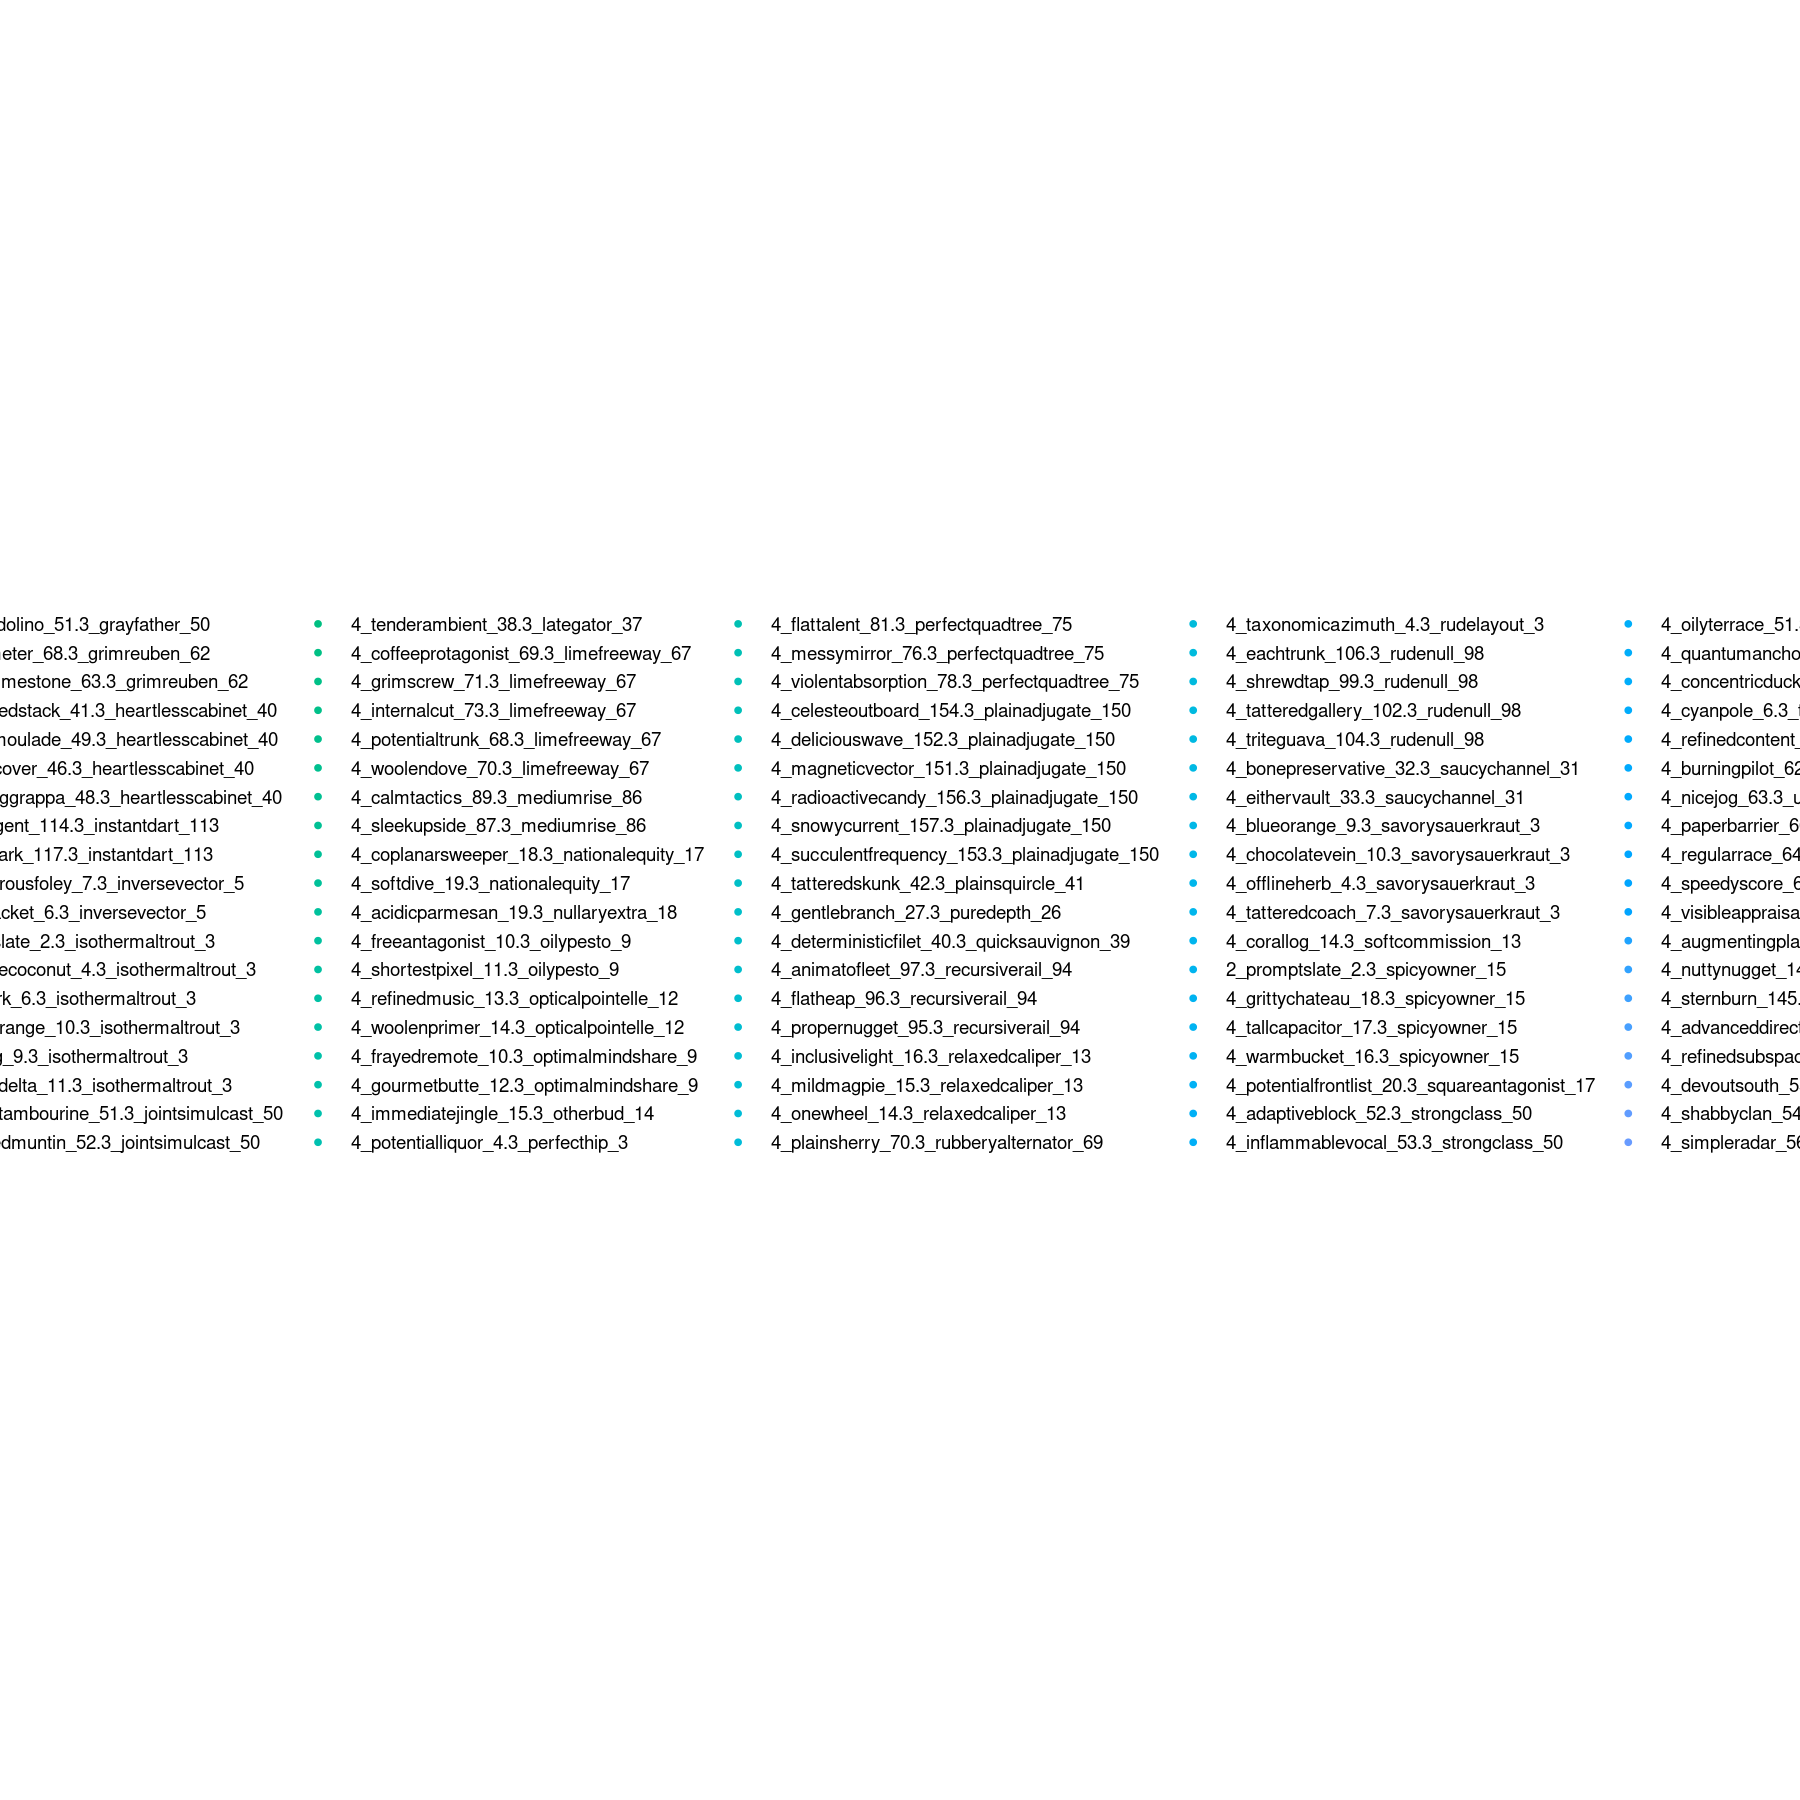

In [264]:
fig(15, 15)
latency %>%
  filter(field == "raw") %>%
  adjust_timestamps() %>%
  ungroup() %>%
  rename(source = instance, destination = destination_name, latency_value = value) %>%
  select(timestamp, source, destination, folder, latency_value, diff) %>%
  ggplot(aes(x= timestamp, y = latency_value, color = interaction(source, destination))) +
  facet_wrap(~folder) +
  geom_point() +
  gghighlight(diff > 3)

In [265]:
time_interval <- 15 # secs

smooth_timestamps <- function(data) {
  return(
    data %>%
      group_by(folder) %>%
      mutate(timestamp_group = as.difftime((as.numeric(round(timestamp)) %/% time_interval + 1) * time_interval, units = "secs")) %>%
      ungroup()
  )
}
if (generate_gif) {


data <- latency %>%
  filter(field == "raw") %>%
  adjust_timestamps() %>%
  ungroup() %>%
  rename(source = instance, destination = destination_name, latency_value = value) %>%
  select(timestamp, source, destination, folder, latency_value, diff) %>%
  smooth_timestamps() %>%
  group_by(timestamp_group, source, destination, folder) %>%
  summarise(latency_value = mean(latency_value), diff = mean(diff)) %>%
  rename(timestamp = timestamp_group) %>%
  ungroup() %>%
  {
    .
  }


nodes <- load_csv("provisioned_functions.csv") %>%
  prepare() %>%
  adjust_timestamps() %>%
  group_by(timestamp, folder, instance) %>%
  mutate(provisioned = ifelse(value == 0, -1, value)) %>%
  summarise(provisioned = sum(provisioned), value = sum(value)) %>%
  group_by(folder, instance) %>%
  arrange(timestamp, .by_group = TRUE) %>%
  mutate(provisioned = lag(cumsum(provisioned), default = 0), total_provisioned = lag(cumsum(value), default = 0)) %>%
  rename(source = instance) %>%
  select(source, timestamp, folder, provisioned, total_provisioned) %>%
  smooth_timestamps() %>%
  group_by(timestamp_group, folder, source) %>%
  summarise(provisioned = last(provisioned), total_provisioned = last(total_provisioned)) %>%
  rename(timestamp = timestamp_group) %>%
  ungroup() %>%
  {
    .
  }
# nodes %>% filter(source == "rennes")
# nodes %>% filter(source == "st_greg_3_in")

cpu <- raw.cpu.observed_from_fog_node %>%
  adjust_timestamps() %>%
  rename(source = instance) %>%
  select(timestamp, source, folder, usage) %>%
  smooth_timestamps() %>%
  group_by(timestamp_group, folder, source) %>%
  summarise(usage = mean(usage)) %>%
  rename(timestamp = timestamp_group) %>%
  ungroup()

gif.apdex.raw <- load_csv("latency_header.csv") %>%
    prepare() %>%
    adjust_timestamps() %>%
    rename(function_name = tag) %>%
    extract_function_name_info() %>%
    smooth_timestamps() %>%
    inner_join(bids_won_function %>% select(sla_id, function_name, metric_group, metric_group_group, folder, winner), by = c("sla_id", "function_name", "folder", "metric_group_group", "metric_group")) %>%
    rename(measured_latency = value, source = winner) %>%
    mutate(apdex_category = interaction(load_type, latency_type)) %>%
    group_by(timestamp_group, sla_id, folder, source, apdex_category) %>%
    summarise(satisfied_count = sum(measured_latency <= latency), total = n()) %>%
    mutate(apdex = satisfied_count / total)

gif.apdex.by_node <- gif.apdex.raw %>%
    group_by(timestamp_group, folder, source) %>%
    summarise(apdex = mean(apdex)) %>%
    rename(timestamp = timestamp_group) %>%
    ungroup()

gif.apdex.by_function_and_node <- gif.apdex.raw %>%
    group_by(timestamp_group, folder, source, apdex_category) %>%
    summarise(apdex = mean(apdex)) %>%
    rename(timestamp = timestamp_group) %>%
    pivot_wider(names_from = apdex_category, values_from = apdex) %>%
    fill(everything(), .direction = "downup") %>%
    distinct() %>%
    ungroup()

all_combinations <- data %>%
  select(folder, source, destination) %>%
  distinct() %>%
  full_join(
    data %>%
      select(timestamp) %>%
      distinct() %>%
      full_join(nodes %>%
        select(timestamp) %>%
        distinct(), by = "timestamp") %>%
      full_join(gif.apdex.by_node %>%
        select(timestamp) %>%
        distinct(), by = "timestamp") %>%
      full_join(gif.apdex.by_function_and_node %>%
        select(timestamp) %>%
        distinct(), by = "timestamp") %>%
      full_join(cpu %>%
        select(timestamp) %>%
        distinct(), by = "timestamp"),
    by = character()
  )


data <- all_combinations %>%
  full_join(data, by = c("timestamp", "folder", "source", "destination")) %>%
  full_join(nodes, by = c("source", "timestamp", "folder")) %>%
  full_join(gif.apdex.by_node, by = c("source", "timestamp", "folder")) %>%
  full_join(cpu, by = c("source", "timestamp", "folder")) %>%
  full_join(gif.apdex.by_function_and_node, by = c("source", "timestamp", "folder")) %>%
  group_by(folder, source, destination) %>%
  arrange(timestamp, .by_group = TRUE) %>%
  fill(diff, provisioned, total_provisioned) %>%
  # mutate(provisioned = ifelse(is.na(provisioned), 0, provisioned)) %>%
  # mutate(total_provisioned = ifelse(is.na(total_provisioned), 0, total_provisioned)) %>%
  # mutate(diff = ifelse(is.na(diff), 0, diff)) %>%
  # mutate(cpu_usage = ifelse(is.na(cpu_usage), 0, cpu_usage)) %>%
  ungroup() %>%
  {
    .
  }

globally_provisioned <- data %>%
  select(source, folder, timestamp, total_provisioned) %>%
  distinct() %>%
  group_by(folder, timestamp) %>%
  summarise(globally_provisioned = sum(total_provisioned)) %>%
  ungroup()

data <- data %>%
  # inner_join(globally_provisioned, by = c("folder", "timestamp")) %>%
  filter(source != destination) %>%
  select(source, destination, everything()) %>%
  rename(from = source, to = destination)
  # adjust_timestamps()

nrow(data)
}


In [266]:
fig(10, 10)

create_plot <- function(data) {
  net <- network(data, directed = TRUE, multiple = TRUE)
  net <- ggnetwork(net)
  name <- as.character(data$folder[1])
  duration <- max(data$timestamp) / time_interval
  print(duration)

  nudge_offset_x <- 0.05
  nudge_offset_y <- -0.3 / 2
  nudge_scale_y = 3

  pggnetwork <-
    ggplot(
      net,
      aes(x = x, y = y, xend = xend, yend = yend)
    ) + # mapping for edges
    geom_edges(
      arrow = arrow(length = unit(3, "pt"), type = "open"), # if directed
      curvature = 0.1,
      aes(size = diff, alpha = latency_value, color = diff)
    ) +
    scale_colour_gradient(low = "green", high = "red", na.value = "grey50") +
    scale_alpha_continuous() +
    new_scale_color() +
    geom_nodes(aes(size = provisioned, color = apdex),
      alpha = 0.5,
    ) +
    scale_colour_gradient(low = "white", high = "darkblue", na.value = "grey50") +
    new_scale_color() +
    geom_nodes(aes(size = provisioned / 16, color = usage),
      alpha = 1,
    ) +
    scale_colour_gradient(low = "green", high = "red", na.value = "grey50") +
    new_scale_color() +
    scale_color_manual(values = c("grey40", "grey80")) +
    geom_nodetext(aes(label = sprintf("sat: %1.2f", apdex)), color = "black", nudge_x = nudge_offset_x, nudge_y = (nudge_offset_y + 0.3)/nudge_scale_y) +
    geom_nodetext(aes(label = sprintf("ll: %1.2f", `Low-load.Low-latency`), colour = is.na(`Low-load.Low-latency`), group = vertex.names), nudge_x = nudge_offset_x, nudge_y = (nudge_offset_y + 0.25) / nudge_scale_y) +
    geom_nodetext(aes(label = sprintf("lh: %1.2f", `Low-load.High-latency`), colour = is.na(`Low-load.High-latency`), group = vertex.names), nudge_x = nudge_offset_x, nudge_y = (nudge_offset_y + 0.2) / nudge_scale_y) +
    geom_nodetext(aes(label = sprintf("hh: %1.2f", `High-load.High-latency`), colour = is.na(`High-load.High-latency`), group = vertex.names), nudge_x = nudge_offset_x, nudge_y = (nudge_offset_y + 0.15) / nudge_scale_y) +
    geom_nodetext(aes(label = sprintf("hl: %1.2f", `High-load.Low-latency`), colour = is.na(`High-load.Low-latency`), group = vertex.names), nudge_x = nudge_offset_x, nudge_y = (nudge_offset_y + 0.1) / nudge_scale_y) +
    geom_nodetext(aes(label = sprintf("f: %02d/%02d", provisioned, total_provisioned)), color = "black", nudge_x = nudge_offset_x, nudge_y = (nudge_offset_y + 0.05) / nudge_scale_y) +
    geom_nodetext(aes(label = sprintf("%s", vertex.names)), color = "grey80", nudge_x = nudge_offset_x, nudge_y = (nudge_offset_y + 0)/nudge_scale_y) +
    # geom_text(x = 0.05, y = 0.95, aes(label = paste0("Globally provisioned:", globally_provisioned)), color = "grey50", check_overlap = TRUE) +
    labs(title = "Time: {as.integer(frame_time)}",
    subtitle= sprintf("'%s'\n
    sat: satisfaction rate\n
    ll: low load low lat. ƒ satisfaction rate\n
    lh: low load high lat. ƒ satisfaction rate\n
    hh: high load high lat. ƒ satisfaction rate\n
    hl: high load low lat. ƒ satisfaction rate\n
    f: <current provisioned>/<total provisioned", name)) +
    transition_time(timestamp) +
    ease_aes("linear") +
    enter_fade() +
    exit_fade() +
    theme_blank() +
    theme(legend.position = "bottom")
  # +
  # facet_grid(cols = vars(folder))

  # out <- ggplot_build(pggnetwork)

  # rows <- max(out$layout$layout$ROW)
  # cols <- max(out$layout$layout$COL)
  print(duration)

  # print(pggnetwork[1])

  anim_save(filename = sprintf("%s.gif", name), animation = pggnetwork, renderer = magick_renderer(), nframes = duration, height = 1600, width = 2000)
}

if (generate_gif) {
  data_grouped <- data %>%
    # filter(timestamp < "15 secs") %>%w
    group_by(folder) %>%
    group_split()

  animations <- lapply(data_grouped, FUN = create_plot)
}
# create_plot(data_grouped[[1]])


In [267]:
total_low_latency <- functions_total %>%
  filter(status == "provisioned") %>%
  filter(latency_type == "Low latency") %>%
  group_by(folder, metric_group, metric_group_group, latency_type) %>%
  summarise(total = sum(total))

total <- functions_total %>%
  filter(status == "provisioned") %>%
  group_by(folder, metric_group, metric_group_group) %>%
  summarise(total = sum(total))

total_low_latency <- total_low_latency %>%
  group_by(folder, metric_group, metric_group_group) %>%
  inner_join(total, by = c("folder", "metric_group", "metric_group_group")) %>%
  mutate(ratio_low_latency_functions = total.x / total.y) %>%
  select(folder, metric_group, metric_group_group, ratio_low_latency_functions)


ratio_low_latency <- functions_total %>%
  filter(status == "provisioned") %>%
  filter(latency_type == "Low latency") %>%
  group_by(folder, metric_group, metric_group_group) %>%
  summarise(n = sum(n)) %>%
  inner_join(total, by = c("metric_group", "folder", "metric_group_group")) %>%
  mutate(ratio_low_latency = n / total)

ratio_total <- functions_total %>%
  filter(status == "provisioned") %>%
  group_by(folder, metric_group, metric_group_group) %>%
  summarise(n = sum(n)) %>%
  inner_join(total, by = c("metric_group", "folder", "metric_group_group")) %>%
  mutate(ratio_total = n / total)


`summarise()` has grouped output by
'folder', 'metric_group',
'metric_group_group'. You can override
using the `.groups` argument.
`summarise()` has grouped output by
'folder', 'metric_group'. You can override
using the `.groups` argument.
`summarise()` has grouped output by
'folder', 'metric_group'. You can override
using the `.groups` argument.
`summarise()` has grouped output by
'folder', 'metric_group'. You can override
using the `.groups` argument.


In [268]:
colnames(total_low_latency)
# colnames(apdex_data)


[1] "folder"                      "metric_group"               
[3] "metric_group_group"          "ratio_low_latency_functions"

In [269]:
raw.deployment_times <-  load_csv("function_deployment_duration.csv") %>%
  prepare() %>%
  prepare_convert() %>%
  extract_function_name_info()
colnames(raw.deployment_times)
# head(deployment_times_raw)


New names:
• `` -> `...1`
New names:
• `` -> `...1`


New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`


[1] "...1"                            "result"                         
 [3] "table"                           "_start"                         
 [5] "_stop"                           "timestamp"                      
 [7] "value"                           "field"                          
 [9] "_measurement"                    "bid_id"                         
[11] "function_name"                   "instance"                       
[13] "sla_id"                          "folder"                         
[15] "metric_group"                    "metric_group_group"             
[17] "docker_fn_name"                  "function_index"                 
[19] "latency"                         "cpu"                            
[21] "mem"                             "load_type"                      
[23] "latency_type"                    "nb_fn_low_interval_low_latency" 
[25] "nb_fn_high_interval_low_latency"

`summarise()` has grouped output by
'folder', 'metric_group_group',
'metric_group', 'load_type'. You can
override using the `.groups` argument.
Joining with `by = join_by(folder)`
Adding missing grouping variables:
`metric_group_group`
Adding missing grouping variables:
`load_type`


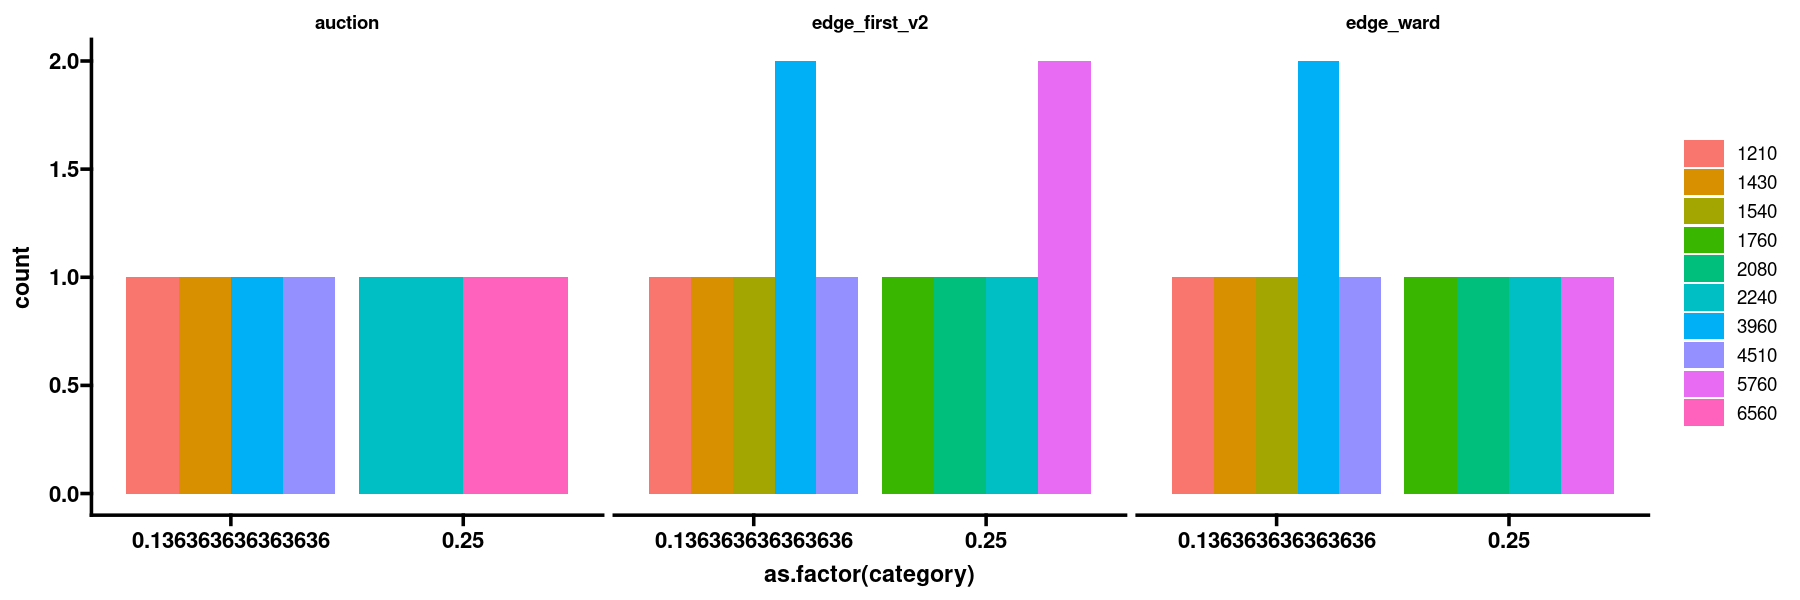

In [270]:
raw.nb_functions <- load_csv("nb_functions.csv") %>%
    rename(load_type = load, latency_type = latency) %>%
    mutate(
    instance = to_snake_case(instance),
    load_type = case_when(
        load_type == "low" ~ "Low load",
        load_type == "high" ~ "High load",
        TRUE ~ "unimplemented",
    ),
    latency_type = case_when(
        latency_type == "low" ~ "Low latency",
        latency_type == "high" ~ "High latency",
        TRUE ~ "unimplemented",
    ))


raw.nb_functions.total <- raw.nb_functions %>%
    group_by(folder, metric_group_group, metric_group, load_type, latency_type) %>%
    summarise(total = sum(value)) %>%
    mutate(folder = gsub(".tar.xz","", folder))

count.total <- raw.nb_functions.total %>% 
    inner_join(raw.nb_functions.total %>% 
        ungroup() %>%
        select(folder, total, latency_type, load_type) %>%
        distinct() %>%
        group_by(folder) %>%
        summarise(sum = sum(total))) %>%
    select(folder, metric_group, sum, total, latency_type, load_type) %>%
    mutate(ratio = total/sum)



raw.function_low_latency_load_category <- count.total %>%
    filter(latency_type == "Low latency" & load_type == "High load") %>%
    select(-c(latency_type, load_type)) %>%
    ungroup() %>%
    select(folder, metric_group, ratio, sum) %>%
    distinct() %>%
    rename(category = ratio, requests = sum)

    # raw.function_low_latency_load_category  %>% group_by(request, category, metric_group) %>% summarise(tot = n())
# count.total
fig(15,5)
raw.function_low_latency_load_category %>%
    ggplot(aes(x = as.factor(category), group = factor(requests), fill = factor(requests))) +
    geom_bar(position = "dodge") +
    facet_wrap(~metric_group)


In [271]:
jains_index <- function(allocations) {
  num_users <- length(allocations)
  sum_allocations <- sum(allocations)
  sum_square_allocations <- sum(allocations^2)
  index <- (sum_allocations^2) / (num_users * sum_square_allocations)
  return(index)
}

# earnings.total_per_instance <- bids_won_function %>%
#   group_by(folder, metric_group, metric_group_group, winner) %>%
#   summarise(earnings = sum(cost))

# folders <- earnings.total_per_instance %>%
#   ungroup() %>%
#   select(folder, metric_group, metric_group_group) %>%
#   distinct()

# missing_data <- expand.grid(
#   winner = node_levels$name,
#   folder = folders$folder
# ) %>%
#   inner_join(folders) %>%
#   anti_join(earnings.total_per_instance %>% ungroup() %>% select(folder, winner))

# earnings.total_per_instance <- earnings.total_per_instance %>%
#   full_join(missing_data, by = c("winner", "folder", "metric_group", "metric_group_group")) %>%
#   mutate(earnings = ifelse(is.na(earnings), 0, earnings)) %>%
#   ungroup() 

# earnings.total <- earnings.total_per_instance %>%
#   group_by(folder, metric_group, metric_group_group) %>%
#   summarise(earnings = sum(earnings))

# earnings.jain <- earnings.total_per_instance %>%
#   inner_join(earnings.total %>% rename(total = earnings), by = c("folder", "metric_group", "metric_group_group")) %>%
#   mutate(earnings_ratio = earnings / total)

# # Calculate Jain's Fairness Index for each group using dplyr
# spider_all.earnings.ratio <- earnings.jain %>%
#   group_by(metric_group, folder, winner, metric_group_group) %>%
#   rename (score = earnings_ratio) %>%
#   mutate(score_type_rich = "Earning shares") 
  
# spider_all.earnings.ratio.highest <- spider_all.earnings.ratio %>%
#   group_by(metric_group, folder, metric_group_group) %>%
#   mutate(score = 1/score) %>%
#   worst_5() %>%
#   mutate(score = 1/score) %>%
#   filter(data_focus == "Worst 5%") %>%
#   mutate(score_type_rich = "Earning shares\n(highest)") %>%
#   summarySE("score", c("data_focus", "folder", "score_type_rich", "metric_group", "metric_group_group"), na.rm = TRUE)

#  spider_all.earnings.ratio <-  spider_all.earnings.ratio %>%
#   group_by(metric_group, folder, metric_group_group) %>%
#   worst_5() %>%
#   summarySE("score", c("data_focus", "folder", "score_type_rich", "metric_group", "metric_group_group"), na.rm = TRUE)

# spider_all.earnings.jain <- earnings.jain %>%
#   group_by(metric_group, folder, metric_group_group) %>%
#   summarise(jains_index = jains_index(earnings_ratio), n = n()) %>%
#   rename(score = jains_index ) %>%
#   mutate(score_type_rich = "Jain's index") %>%
#   mutate(data_focus = "All") %>%
#   summarySE("score", c("data_focus", "folder", "score_type_rich", "metric_group", "metric_group_group"), na.rm = TRUE) 

# spider_all.auc_usage.cpu <- raw.auc_usage.cpu %>%
#   select(metric_group, folder, instance, usage_ratio, metric_group_group) %>%
#   rename(source = instance, score = usage_ratio) %>%
#   mutate(score = as.numeric(score)) %>%
#   mutate(score_type_rich = "CPU Usage") %>%
#   group_by(score_type_rich, metric_group, folder, metric_group_group) %>%
#   worst_5() %>%
#   ungroup %>%
#   summarySE("score", c("data_focus", "folder", "score_type_rich", "metric_group", "metric_group_group"), na.rm = TRUE) 



# spider_all.auc_usage.mem <- raw.auc_usage.mem %>%
#   select(metric_group, folder, instance, usage_ratio, metric_group_group) %>%
#   rename(source = instance, score = usage_ratio) %>%
#   mutate(score = as.numeric(score)) %>%
#   mutate(score_type_rich = "Mem Usage") %>%
#   group_by(score_type_rich, metric_group, folder, metric_group_group) %>%
#   worst_5() %>%
#   summarySE("score", c("data_focus", "folder", "score_type_rich", "metric_group", "metric_group_group"), na.rm = TRUE) 

# spider_all.functions_total <- functions_total %>%
#     filter(status == "provisioned") %>%
#     inner_join(raw.nb_functions.total %>% rename(all = total)) %>%
#     mutate (score = n / all) %>%
#     mutate(score_type_rich = sprintf("Provisioned fns\n%s %s", load_type, latency_type)) %>%
#     ungroup() %>%
#     select(score, score_type_rich, folder, metric_group, metric_group_group)  %>%
#     mutate(data_focus = "All") 


# spider_all.deployment_times <- raw.deployment_times %>%
#   ungroup() %>%
#   select(load_type, sla_id, load_type, latency_type, function_name, folder,  metric_group, value, metric_group_group) %>%
#   mutate(score = 1000/value) %>%
#   mutate(score_type_rich = sprintf("Deployment time\n%s %s", load_type, latency_type)) %>%
#   select(score, score_type_rich, folder, metric_group, sla_id, metric_group_group) %>%
#   group_by(folder, metric_group, score_type_rich, metric_group_group) %>%
#   worst_5() %>%
#   mutate(score = 1/score) %>%
#   summarySE("score", c("folder", "score_type_rich", "metric_group", "data_focus", "metric_group_group"), na.rm = TRUE) 

# bounds <- function(df){
#   df %>% 
#     mutate(lower.ci.score = score - ci) %>%
#     mutate(upper.ci.score = score + ci) 
# }

In [272]:
# fig(15, 15)

# ecdf.earnings <- earnings.jain %>%
#     rename (score = earnings_ratio) %>%
#     inner_join(raw.function_low_latency_load_category) 

In [273]:
colnames(functions)

raw.nb_functions.total.full <- raw.nb_functions.total %>% 
        ungroup() %>%
        select(folder, total, latency_type, load_type) %>%
        distinct() %>%
        group_by(folder) %>%
        summarise(total = sum(total))
raw.nb_functions.total.ll <- raw.nb_functions.total %>% 
        ungroup() %>%
        filter(latency_type == "Low latency") %>%
        select(folder, total, latency_type, load_type) %>%
        distinct() %>%
        group_by(folder) %>%
        summarise(total = sum(total))



[1] "instance"           "folder"             "metric_group"      
[4] "metric_group_group" "load_type"          "latency_type"      
[7] "status"             "n"

`summarise()` has grouped output by
'folder', 'winner'. You can override using
the `.groups` argument.
Joining with `by = join_by(winner, folder,
metric_group)`
`summarise()` has grouped output by
'metric_group'. You can override using the
`.groups` argument.
Joining with `by = join_by(folder)`


Joining with `by = join_by(folder)`
Warning message:
“Computation failed in
`stat_compare_multiple_means()`
Caused by error in `mutate()`:
ℹ In argument: `data =
  map(.data$data, .f, ...)`.
Caused by error in `map()`:
ℹ In index: 1.
Caused by error in `assertthat_iv_has_enough_levels()`:
! Variable grouphas only one level. Remove it from the model.”
Warning message:
“Computation failed in
`stat_compare_multiple_means()`
Caused by error in `mutate()`:
ℹ In argument: `data =
  map(.data$data, .f, ...)`.
Caused by error in `map()`:
ℹ In index: 1.
Caused by error in `assertthat_iv_has_enough_levels()`:
! Variable grouphas only one level. Remove it from the model.”


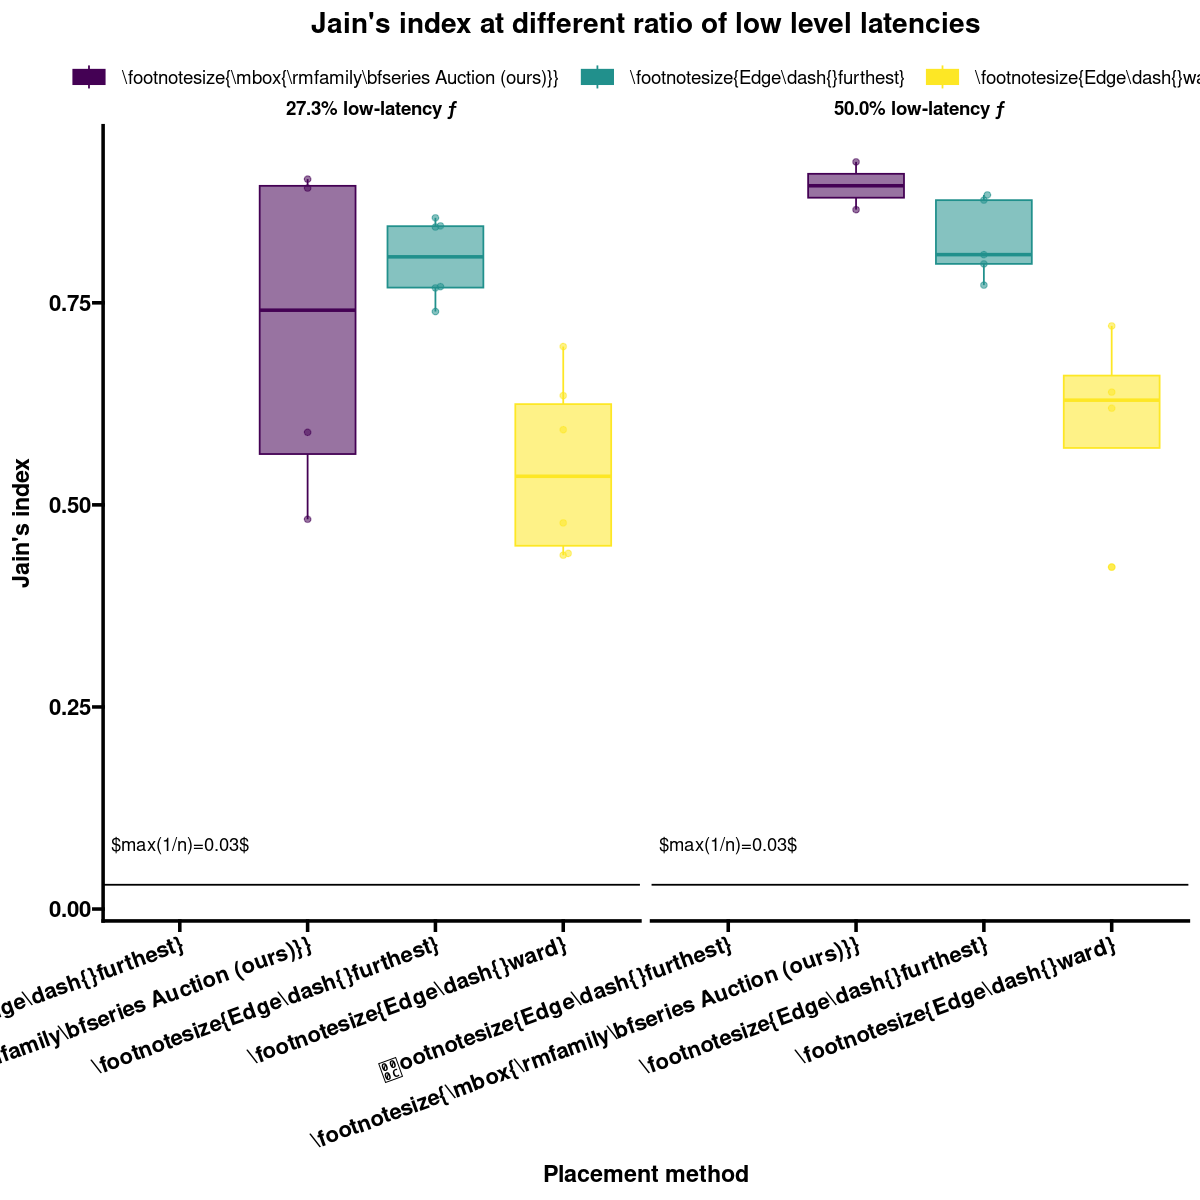

In [889]:
earnings.jains.plot.data.raw <- node_levels %>%
    rename(winner = name) %>%
    full_join(bids_won_function %>% group_by(folder, winner, metric_group) %>% summarise(earnings = sum(cost))) %>%
    mutate(earnings = ifelse(is.na(earnings), 0, earnings)) %>%
    group_by(metric_group, folder) %>%
    summarise(jains_index = jains_index(earnings), worst_case = round(1 / n(), 2), n = n()) %>%
    rename(score = jains_index ) %>%
    left_join(raw.nb_functions.total.full %>% rename(total_func = total)) %>%
    left_join(raw.nb_functions.total.ll %>% rename(total_func_ll = total)) %>%
    rowwise() %>%
    mutate(ratio_func_ll = total_func_ll / total_func) %>%
    correct_names()

plots.jains.w <- GRAPH_ONE_COLUMN_WIDTH
plots.jains.h <- GRAPH_ONE_COLUMN_HEIGHT
plots.jains.caption <- "Jain's index at different ratio of low level latencies"
fig(plots.jains.w, plots.jains.h)

my_comparisons = combn(unique(earnings.jains.plot.data.raw$`Placement method`), 2)
my_comparisons = apply(my_comparisons, 2, list)
my_comparisons <- lapply(my_comparisons, unlist)
fig(10, 10)
plots.jains <- earnings.jains.plot.data.raw %>%
    ggplot(aes(alpha=1, x = `Placement method`, y = score, fill = `Placement method`, color = `Placement method`)) +
    facet_grid(cols = vars(sprintf("%.1f%% low-latency ƒ", ratio_func_ll * 100))) +
    geom_hline(yintercept = max(earnings.jains.plot.data.raw$worst_case), color = "black") +
    annotate("text", x="\footnotesize{Edge\\dash{}furthest}", y=max(earnings.jains.plot.data.raw$worst_case)+.05, label=sprintf("$max(1/n)=%s$", max(earnings.jains.plot.data.raw$worst_case)), color="black") +
    geom_boxplot() +
    geom_beeswarm() +
    # stat_compare_means(comparisons = my_comparisons, label = "p.signif") +
    stat_anova_test() +
    labs(
        x = "Placement method",
        y = "Jain's index"
    ) +
    scale_alpha_continuous(guide = "none") +
    guides(color = guide_legend(nrow = 1), shape = guide_legend(nrow = 1), size = guide_legend(nrow = 1)) +
    theme(legend.background = element_rect(
        fill = alpha("white", .7),
        size = 0.2, color = "white"),
        axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)
    ) +
    theme(legend.position = "top", legend.box = "vertical") +
    scale_color_viridis(discrete = T) +
    scale_fill_viridis(discrete = T)+
    theme(legend.spacing.y = unit(0, "cm"), legend.margin = margin(0, 0, 0, 0), legend.box.margin = margin(0, -10, -10, -10), )

plots.jains + labs(title = plots.jains.caption)


## Nb of respected SLAs

In [275]:
if (reload_big_data) {
    registerDoParallel(cl = parallel_loading_datasets, cores = parallel_loading_datasets)
    respected_sla.header.nb <- foreach (ark = METRICS_ARKS) %dopar% {

        # max_timestamp <- data %>%
        #     group_by(folder, metric_group, metric_group_group) %>%
        #     summarise(max_timestamp = max(timestamp))
        gc()

        load_single_csv(ark, "latency_header.csv") %>%
            prepare() %>%
            adjust_timestamps() %>%
            rename(function_name = tag) %>%
            extract_function_name_info() %>%
        # data %>%
            # left_join(max_timestamp) %>%
            group_by(sla_id, folder, metric_group, metric_group_group, latency_type, load_type, function_name) %>%
            summarise(
                satisfied_count = sum(value <= latency),
                acceptable_count = sum(value <= latency + 0.001),
                alt_satisfied_count = sum(value / 2 <= latency), 
                alt_satisfied_count2 = sum(value / 4 <= latency), 
                alt_acceptable_count = sum(value / 2 <= latency + 0.01), 
                total = n(), 
                measured_latency = mean(value), 
                ran_for = max(timestamp) - min(timestamp), 
                # finished_before_end_expe = max(timestamp) < max_timestamp
                ) %>%
            mutate(count.satisfied = satisfied_count / total) %>%
            mutate(count.acceptable = acceptable_count / total) %>%
            mutate(count.alt2 = alt_satisfied_count2 / total) %>%
            mutate(count.alt = alt_satisfied_count / total)
    }

    respected_sla.header.nb <- bind_rows(respected_sla.header.nb)
    respected_sla.header.nb %>% write.csv(.,file = "./respected_sla.header.nb.csv")
}

gc()
respected_sla.header.nb <- read.csv("./respected_sla.header.nb.csv")

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4648719,248.3,13229997,706.6,29864827,1595.0
Vcells,119981927,915.4,358938544,2738.5,560788373,4278.5


In [276]:
if (reload_big_data) {
    registerDoParallel(cl = parallel_loading_datasets, cores = parallel_loading_datasets)
    respected_sla.nb <- foreach (ark = METRICS_ARKS) %dopar% {

        # max_timestamp <- data %>%
        #     group_by(folder, metric_group, metric_group_group) %>%
        #     summarise(max_timestamp = max(timestamp))
        gc()


        load_single_csv(ark, "latency.csv") %>%
            prepare() %>%
            adjust_timestamps() %>%
            rename(function_name = tag) %>%
            extract_function_name_info() %>%
        # data %>%
            # left_join(max_timestamp) %>%
            group_by(sla_id, folder, metric_group, metric_group_group, latency_type, load_type, function_name) %>%
            summarise(
                satisfied_count = sum(value <= latency),
                acceptable_count = sum(value <= latency + 0.001),
                alt_satisfied_count = sum(value / 2 <= latency), 
                alt_satisfied_count2 = sum(value / 4 <= latency), 
                alt_acceptable_count = sum(value / 2 <= latency + 0.01), 
                total = n(), 
                measured_latency = mean(value), 
                ran_for = max(timestamp) - min(timestamp), 
                # finished_before_end_expe = max(timestamp) < max_timestamp
                ) %>%
            mutate(count.satisfied = satisfied_count / total) %>%
            mutate(count.acceptable = acceptable_count / total) %>%
            mutate(count.alt2 = alt_satisfied_count2 / total) %>%
            mutate(count.alt = alt_satisfied_count / total)
    }

    respected_sla.nb <- bind_rows(respected_sla.nb)
    respected_sla.nb %>% write.csv(.,file = "./respected_sla.nb.csv")
}

gc()
respected_sla.nb <- read.csv("./respected_sla.nb.csv")

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4648633,248.3,13229997,706.6,29864827,1595.0
Vcells,120067002,916.1,358938544,2738.5,560788373,4278.5


In [277]:
slice_sample(respected_sla.header.nb %>% filter(measured_latency > 0), n = 5)

X,sla_id,folder,metric_group,metric_group_group,latency_type,load_type,function_name,satisfied_count,acceptable_count,alt_satisfied_count,alt_satisfied_count2,alt_acceptable_count,total,measured_latency,ran_for,count.satisfied,count.acceptable,count.alt2,count.alt
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
17455,eeb58168-882c-4beb-b567-30d0709638cc,metrics_valuation_rates.env_1-edge_ward_valuation_rates_no-telemetry_2023-09-22-20-18,edge_ward,toto,High-latency,Low-load,echo-40-84-200-200-high-high-15-15,341,341,341,341,341,341,0.024838710,299.991,1,1,1,1
39761,58a9071c-50f2-4a7a-9803-b3c794fa5b0c,metrics_valuation_rates.env_5-edge_ward_valuation_rates_no-telemetry_2023-09-22-22-27,edge_ward,toto,High-latency,Low-load,echo-63-120-200-200-high-high-15-15,184,184,184,184,184,184,0.031891304,142.999,1,1,1,1
29568,1339de3a-b1bb-4071-a1e9-2fa62eb3e154,metrics_valuation_rates.env_4-edge_ward_valuation_rates_no-telemetry_2023-09-23-12-42,edge_ward,toto,High-latency,Low-load,echo-40-109-200-200-high-high-15-15,76,76,76,76,76,76,0.005486842,35.002,1,1,1,1
52732,09fb7c30-a90a-4daa-839a-311a047efb7f,metrics_valuation_rates.env_8-edge_ward_valuation_rates_no-telemetry_2023-09-23-00-09,edge_ward,toto,High-latency,High-load,echo-134-124-400-400-low-high-40-40,42501,42501,42501,42501,42501,42501,0.001898355,299.998,1,1,1,1
24940,8c3d0967-e8df-4438-af13-8cffc2dfa895,metrics_valuation_rates.env_4-auction_valuation_rates_no-telemetry_2023-09-23-11-12,auction,toto,Low-latency,Low-load,echo-11-17-200-200-high-low-15-15,275,275,275,275,275,275,0.002556364,234.000,1,1,1,1


In [895]:
# respected_sla.header.nb %>%
#     left_join(respected_sla.nb %>%
#         select(sla_id, folder, measured_latency) %>%
#         rename(og_measured_latency = measured_latency)) %>%
#     extract_function_name_info() %>%
#     mutate(measured_latency = (og_measured_latency - abs(measured_latency)) * 1000) %>%
#     left_join(raw.nb_functions.total.full %>% rename(total_func = total)) %>%
#     left_join(raw.nb_functions.total.ll %>% rename(total_func_ll = total)) %>%
#     rowwise() %>%
#     mutate(ratio_func_ll = total_func_ll / total_func) %>%
#     group_by(folder, metric_group, latency_type, load_type) %>%
#     summarise(sd= sd(measured_latency), measured_latency = mean(measured_latency))

In [896]:
slice_sample(respected_sla.header.nb %>% filter(metric_group == "auction"), n = 2)

X,sla_id,folder,metric_group,metric_group_group,latency_type,load_type,function_name,satisfied_count,acceptable_count,alt_satisfied_count,alt_satisfied_count2,alt_acceptable_count,total,measured_latency,ran_for,count.satisfied,count.acceptable,count.alt2,count.alt
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4362,3018a658-68b8-4657-89c6-41295815258b,metrics_valuation_rates.env_11-auction_valuation_rates_no-telemetry_2023-09-23-00-27,auction,toto,High-latency,High-load,echo-149-83-400-400-low-high-40-40,2081,2081,2082,2082,2082,2082,0.04434486,187.023,0.9995197,0.9995197,1,1
26281,f9ca145e-62e1-44d4-8d72-706fc65de019,metrics_valuation_rates.env_4-auction_valuation_rates_no-telemetry_2023-09-23-11-12,auction,toto,High-latency,High-load,echo-79-107-400-400-low-high-15-15,2680,2680,2681,2681,2681,2681,0.05521485,299.807,0.9996270,0.9996270,1,1


In [897]:
colnames(respected_sla.nb)

[1] "X"                    "sla_id"               "folder"              
 [4] "metric_group"         "metric_group_group"   "latency_type"        
 [7] "load_type"            "function_name"        "satisfied_count"     
[10] "acceptable_count"     "alt_satisfied_count"  "alt_satisfied_count2"
[13] "alt_acceptable_count" "total"                "measured_latency"    
[16] "ran_for"              "count.satisfied"      "count.acceptable"    
[19] "count.alt2"           "count.alt"

In [899]:
node_levels %>% group_by(folder) %>% summarise(nb_nodes = n())

folder,nb_nodes
<chr>,<int>
metrics_valuation_rates.env_1-auction_valuation_rates_no-telemetry_2023-09-22-19-38,34
metrics_valuation_rates.env_1-edge_first_v2_valuation_rates_no-telemetry_2023-09-22-18-59,34
metrics_valuation_rates.env_1-edge_ward_valuation_rates_no-telemetry_2023-09-22-20-18,34
metrics_valuation_rates.env_10-edge_first_v2_valuation_rates_no-telemetry_2023-09-22-23-30,113
metrics_valuation_rates.env_11-auction_valuation_rates_no-telemetry_2023-09-23-00-27,119
metrics_valuation_rates.env_12-edge_first_v2_valuation_rates_no-telemetry_2023-09-23-01-18,112
metrics_valuation_rates.env_12-edge_ward_valuation_rates_no-telemetry_2023-09-23-02-05,112
metrics_valuation_rates.env_2-edge_first_v2_valuation_rates_no-telemetry_2023-09-22-20-06,32
metrics_valuation_rates.env_2-edge_ward_valuation_rates_no-telemetry_2023-09-22-18-59,32


In [898]:
plots.nb_deployed.data <- respected_sla.header.nb %>%
    extract_function_name_info() %>%
    left_join(raw.nb_functions.total.full %>% rename(total_func = total)) %>%
    left_join(raw.nb_functions.total.ll %>% rename(total_func_ll = total)) %>%
    left_join(node_levels %>% group_by(folder) %>% summarise(nb_nodes = n())) %>%
    mutate(nb_nodes_group = case_when(
        nb_nodes < 19 ~ "Danger zone 1",
        nb_nodes <= 34 ~ "$19 \\le n < 34$",
        # nb_nodes < 40 ~ "$20 < n < 40$",
        nb_nodes < 119 ~ "Danger zone 2",
        nb_nodes <= 119 ~ "$112 \\le n \\le 119$",
        TRUE ~ "Danger zone 3",
    )) %>%
    mutate(ratio_func_ll = total_func_ll / total_func) %>%
    group_by(folder, metric_group, total_func, nb_nodes_group) %>%
    summarise(nb_functions = n()) %>%
    mutate(nb_functions = nb_functions/total_func) %>%
    correct_names()
    # mutate(ratio_func_ll = sprintf("%.1f%% low lat. ƒ", ratio_func_ll *100)) 

plots.nb_deployed.h <- GRAPH_ONE_COLUMN_HEIGHT
plots.nb_deployed.w <- GRAPH_ONE_COLUMN_WIDTH
# plots.nb_deployed.caption = "Ratio of deployed functions over the targeted number"
# fig(plots.nb_deployed.w, plots.nb_deployed.h)

# my_comparisons = combn(unique(plots.nb_deployed.data$`Placement method`), 2)
# my_comparisons = apply(my_comparisons, 2, list)
# my_comparisons <- lapply(my_comparisons, unlist)
# fig(10, 10)
# plots.nb_deployed <- plots.nb_deployed.data %>%
#     ggplot(aes(alpha =1,x = `Placement method`, y = nb_functions, color =`Placement method`)) +
#     # facet_grid(cols = vars(nb_nodes_group)) +
#     stat_summary(fun = mean, geom = "col", fill = "transparent") +
#     geom_boxplot() +
#     geom_beeswarm() +
#     # stat_compare_means(comparisons = my_comparisons, label = "p.signif") + 
#     stat_anova_test() +
#     scale_y_continuous(label = scales::percent) +
#     labs(
#         x = "Placement methods",
#         y = "% of functions placed",
#     ) +
#      theme( legend.background = element_rect(fill=alpha("white", .7),
#                                   size=0.2, color = alpha("white", .7))) +
#         theme(legend.spacing.y = unit(0, 'cm'),      legend.margin=margin(0,0,0,0),         legend.box.margin=margin(-10,-10,-10,-10),)+
#     theme(legend.position = "top") +
#     scale_alpha_continuous(guide = "none") +
#     scale_color_viridis(discrete = T) +
#     scale_fill_viridis(discrete = T)+
#     guides(colour = guide_legend(nrow = 1))

# plots.nb_deployed + labs (title = plots.nb_deployed.caption)


# my_comparisons = combn(unique(plots.nb_deployed.data$nb_nodes_group), 2)
# my_comparisons = apply(my_comparisons, 2, list)
# my_comparisons <- lapply(my_comparisons, unlist)
# plots.nb_deployed <- plots.nb_deployed.data %>%
#     ggplot(aes(alpha= 1, x = nb_nodes_group, y = nb_functions, color =`Placement method`)) +
#     facet_grid(cols = vars(`Placement method`)) +
#     stat_summary(fun = mean, geom = "col", mapping = aes(fill =`Placement method`)) +
#     geom_boxplot() +
#     geom_beeswarm() +
#     stat_compare_means(comparisons = my_comparisons, label = "p.signif") +  
#     stat_summary(fun = mean, geom = "text", mapping = aes(label=sprintf("\\footnotesize{$\\mu=%.1f%%$}",..y..*100)), position = position_stack(vjust = .5, reverse = T), color = "black") +
#     scale_y_continuous(label = scales::percent) +
#     scale_alpha_continuous(guide = "none") +
#     labs(
#         x = "bucketed number of nodes $n$ in the fog network",
#         y = "% of functions placed",
#     ) +
#      theme( legend.background = element_rect(fill=alpha("white", .7),
#                                   size=0.2, color = alpha("white", .7))) +
#     theme(legend.spacing.y = unit(0, 'cm'),      legend.margin=margin(0,0,0,0),         legend.box.margin=margin(-10,-10,-10,-10),)+
#     theme(axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)) +
#     theme(legend.position = "top") +
#     theme(legend.position = "null") +
#     guides(colour = guide_legend(nrow = 1)) +
#     scale_color_viridis(discrete = T) +
#     scale_fill_viridis(discrete = T)

# plots.nb_deployed + labs (title = plots.nb_deployed.caption)

Joining with `by = join_by(folder)`
Joining with `by = join_by(folder)`
Joining with `by = join_by(folder)`
`summarise()` has grouped output by
'folder', 'metric_group', 'total_func'.
You can override using the `.groups`
argument.


In [900]:

plots.respected_sla.data <- respected_sla.header.nb %>%
    extract_function_name_info() %>%
    left_join(raw.nb_functions.total.full %>% rename(total_func = total)) %>%
    left_join(raw.nb_functions.total.ll %>% rename(total_func_ll = total)) %>%
    rowwise() %>%
    mutate(ratio_func_ll = total_func_ll / total_func) %>%
    # mutate(satisfied_count = count.acceptable) %>%
    mutate(satisfied_count = abs(measured_latency - latency) / latency) %>%
    mutate(measured_latency = abs(measured_latency) / latency) %>%
    mutate(ratio_func_ll = sprintf("%.1f%% low-latency ƒ", ratio_func_ll *100))  %>%
    correct_names() %>%
    # mutate(group = sprintf("%s\n%s\n%s", latency_type, load_type, ratio_func_ll))
    mutate(group = latency_type)


Joining with `by = join_by(folder)`
Joining with `by = join_by(folder)`


In [1239]:
generate_label_df <- function(TUKEY, variable){
 
     # Extract labels and factor levels from Tukey post-hoc 
     Tukey.levels <- TUKEY[[variable]][,4]
     Tukey.labels <- data.frame(multcompLetters(Tukey.levels)['Letters'])
     
     #I need to put the labels in the same order as in the boxplot :
     Tukey.labels$class_x=rownames(Tukey.labels)
     Tukey.labels=Tukey.labels[order(Tukey.labels$class_x) , ]
     return(Tukey.labels)
     }

anova_boxplot <- function(p, df, x, y, facet, mean_cb){
     xvar <- rlang::sym(x)
     yvar <- rlang::sym(y)
     facetvar <- rlang::sym(facet)

     df <- df %>% 
          rename(value_y = !!y) %>%
          rename(class_x = !!x) %>%
          rename(var_facet = !!facetvar) %>%
          select(class_x, value_y, var_facet)

     max_yvalue <- max(df$value_y)
     min_yvalue <- min(df$value_y)

     min_mean <- df %>%
          group_by(var_facet, class_x) %>%
          summarise(mean = mean(value_y))
     min_mean <- min(min_mean$mean)/2
     max_pt <- max(df$value_y)

     for (facetk in as.character(unique(df$var_facet))) {   
          subdf.raw <- subset(df, var_facet==facetk)
          subdf <- subdf.raw %>% select(-var_facet)
          ANOVA=aov(subdf$value_y ~ subdf$class_x)
          TUKEY <- TukeyHSD(x=ANOVA, 'subdf$class_x', conf.level=0.95)

          labels <- generate_label_df(TUKEY , 'subdf$class_x')
          names(labels) <- c('Letters','class_x')
          yvalue <- aggregate(.~class_x, data=subdf, quantile, probs=.75)  
          final.box <- subdf.raw %>% inner_join(labels)
          final.text <- merge(labels, yvalue)
          final.text$var_facet <- facetk
          final.text <- final.text %>% inner_join(subdf %>% group_by(class_x) %>% summarise(mean = mean(value_y)))
          
          display(head(summary(ANOVA)))

          if (summary(ANOVA)[[1]][["Pr(>F)"]][1] <= 0.05){
               p <- p + 
                    stat_summary(data = final.box, fun = mean, geom = "col", mapping = aes(x=class_x, y=value_y, fill = Letters)) +
                    geom_beeswarm(data = final.box, aes(x=class_x, y=value_y, fill=Letters, color = Letters)) +
                    geom_boxplot(data = final.box, aes(x=class_x, y=value_y, fill=Letters, color = Letters), outlier.shape = NA) +
                    geom_text(data = final.text,  alpha= 1, aes(x=class_x, y=min_mean, label=mean_cb(Letters, mean))) #vjust=-1.5, hjust=-.5

          }else{
               p <- p + 
                    stat_summary(data = final.box, fun = mean, geom = "col", mapping = aes(x=class_x, y=value_y)) +
                    geom_beeswarm(data = final.box, aes(x=class_x, y=value_y)) +
                    geom_boxplot(data = final.box, aes(x=class_x, y=value_y), outlier.shape = NA) +
                    geom_text(data = final.text,  alpha= 1, aes(x=class_x, y=min_mean, label=mean_cb("\\dash{}", mean) )) #vjust=-1.5, hjust=-.5
          }

          display(head(final.text))

          sumup.F <- summary(ANOVA)[[1]][["F value"]][1]
          sumup.p <- summary(ANOVA)[[1]][["Pr(>F)"]][1]
          sumup.p <- case_when(
               sumup.p < 0.001 ~ "$p<0.001$",
               sumup.p < 0.01 ~ "$p<0.01$",
               sumup.p < 0.05 ~ "$p<0.05$",
               # sumup.p < 0.1 ~ "$p<0.1$",
               TRUE ~ "$p$ is ns"
               )

          final.text <- final.text %>% filter(class_x == subdf$class_x[[1]]) %>% mutate(y = max_pt)

          p <- p + 
               # geom_text(data = final.text,  alpha= 1, aes(x=class_x, y=min_yvalue, label=sprintf("\\footnotesize{$\\mu=%.1f%%$}",mean*100))) +
               # geom_text(data = final.text,  alpha= 1, aes(x=class_x, y=min_yvalue, label=sprintf("%.1f%%",mean*100))) +
               # stat_anova_test(data= final.box, mapping=aes(x=class_x, y=value_y))
               # annotate(data=final.box, geom = "text", color="black", x= subdf$class_x[[1]], y = max_mean * 1.01, label=sprintf("\\footnotesize{Anova $F=%.1f$, %s}", sumup.F, sumup.p))
               geom_text(data=final.text, aes(x= class_x, y = y * 1.01),hjust = 0, color = "black", label=sprintf("\\footnotesize{Anova $F=%.1f$, %s}", sumup.F, sumup.p))
     }

     return(p)
}


`summarise()` has grouped output by
'folder', 'Placement method'. You can
override using the `.groups` argument.


`summarise()` has grouped output by
'var_facet'. You can override using the
`.groups` argument.
Joining with `by = join_by(class_x)`
Joining with `by = join_by(class_x)`


              Df   Sum Sq   Mean Sq F value   Pr(>F)    
subdf$class_x  2 0.001194 0.0005969   13.43 0.000122 ***
Residuals     24 0.001066 0.0000444                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

,class_x,Letters,value_y,var_facet,mean
,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,\footnotesize{\mbox{\rmfamily\bfseries Auction (ours)}},ab,0.9888409,High-latency,0.9879476
2,\footnotesize{Edge\dash{}furthest},a,0.9889328,High-latency,0.9810879
3,\footnotesize{Edge\dash{}ward},b,0.9978183,High-latency,0.9961811


Joining with `by = join_by(class_x)`
Joining with `by = join_by(class_x)`


              Df Sum Sq Mean Sq F value   Pr(>F)    
subdf$class_x  2 0.5052 0.25258   54.05 1.29e-09 ***
Residuals     24 0.1121 0.00467                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

,class_x,Letters,value_y,var_facet,mean
,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,\footnotesize{\mbox{\rmfamily\bfseries Auction (ours)}},a,0.9511822,Low-latency,0.9472850
2,\footnotesize{Edge\dash{}furthest},a,0.9168459,Low-latency,0.9019623
3,\footnotesize{Edge\dash{}ward},b,0.7299166,Low-latency,0.6369544


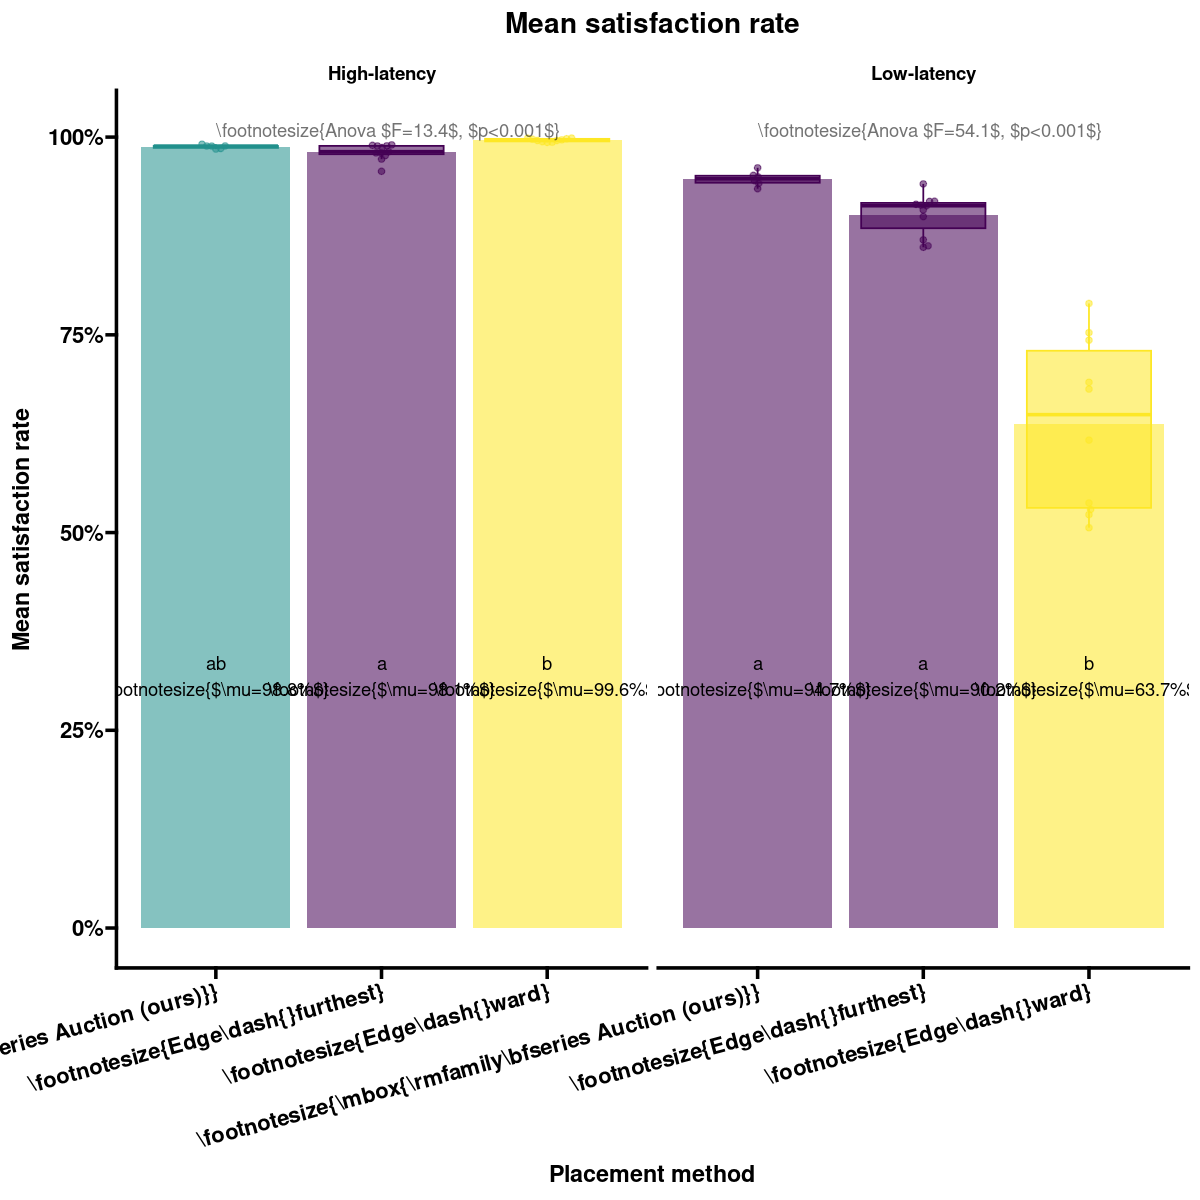

In [1240]:
df <- plots.respected_sla.data %>%
    group_by(folder, `Placement method`, group) %>%
    summarise(satisfied_count = mean(count.acceptable)) %>%
    ungroup()

p <- ggplot(data=df, aes(alpha=1)) +  
     facet_grid(~var_facet) +
     theme( legend.background = element_rect(fill=alpha("white", .7),
                                  size=0.2, color = alpha("white", .7))) +
        theme(legend.spacing.y = unit(0, 'cm'),      legend.margin=margin(0,0,0,0),         legend.box.margin=margin(-10,-10,-10,-10),)+
        theme(axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)) +
    theme(legend.position = "none") +
    scale_color_viridis(discrete = T) +
    scale_fill_viridis(discrete = T)+
    scale_y_continuous(labels = scales::percent) +
    labs(
        x = "Placement method",
        y = "Mean satisfaction rate")

fig(10, 10)
plots.respected_sla.w <- GRAPH_ONE_COLUMN_WIDTH
plots.respected_sla.h <- GRAPH_ONE_COLUMN_HEIGHT
plots.respected_sla.caption <- "Mean satisfaction rate"
mean_cb <- function(Letters, mean){
    return(sprintf("%s\n\\footnotesize{$\\mu=%.1f%%$}",Letters, mean*100))
}
plots.respected_sla <- anova_boxplot(p, df, "Placement method", "satisfied_count", "group", mean_cb)
plots.respected_sla + labs(title = plots.respected_sla.caption)

`summarise()` has grouped output by
'var_facet'. You can override using the
`.groups` argument.
Joining with `by = join_by(class_x)`
Joining with `by = join_by(class_x)`


              Df  Sum Sq  Mean Sq F value Pr(>F)  
subdf$class_x  2 0.04137 0.020684   2.931  0.092 .
Residuals     12 0.08469 0.007057                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

,class_x,Letters,value_y,var_facet,mean
,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,\footnotesize{\mbox{\rmfamily\bfseries Auction (ours)}},a,0.8669421,$19 \le n < 40$,0.8175448
2,\footnotesize{Edge\dash{}furthest},a,0.7845030,$19 \le n < 40$,0.7207032
3,\footnotesize{Edge\dash{}ward},a,0.8960539,$19 \le n < 40$,0.8322348


Joining with `by = join_by(class_x)`
Joining with `by = join_by(class_x)`


              Df  Sum Sq Mean Sq F value Pr(>F)  
subdf$class_x  2 0.08112 0.04056   6.261 0.0198 *
Residuals      9 0.05831 0.00648                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

,class_x,Letters,value_y,var_facet,mean
,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,\footnotesize{\mbox{\rmfamily\bfseries Auction (ours)}},a,0.7985957,$60 < n < 130$,0.7493687
2,\footnotesize{Edge\dash{}furthest},a,0.7514412,$60 < n < 130$,0.7017971
3,\footnotesize{Edge\dash{}ward},b,0.6005174,$60 < n < 130$,0.5498427


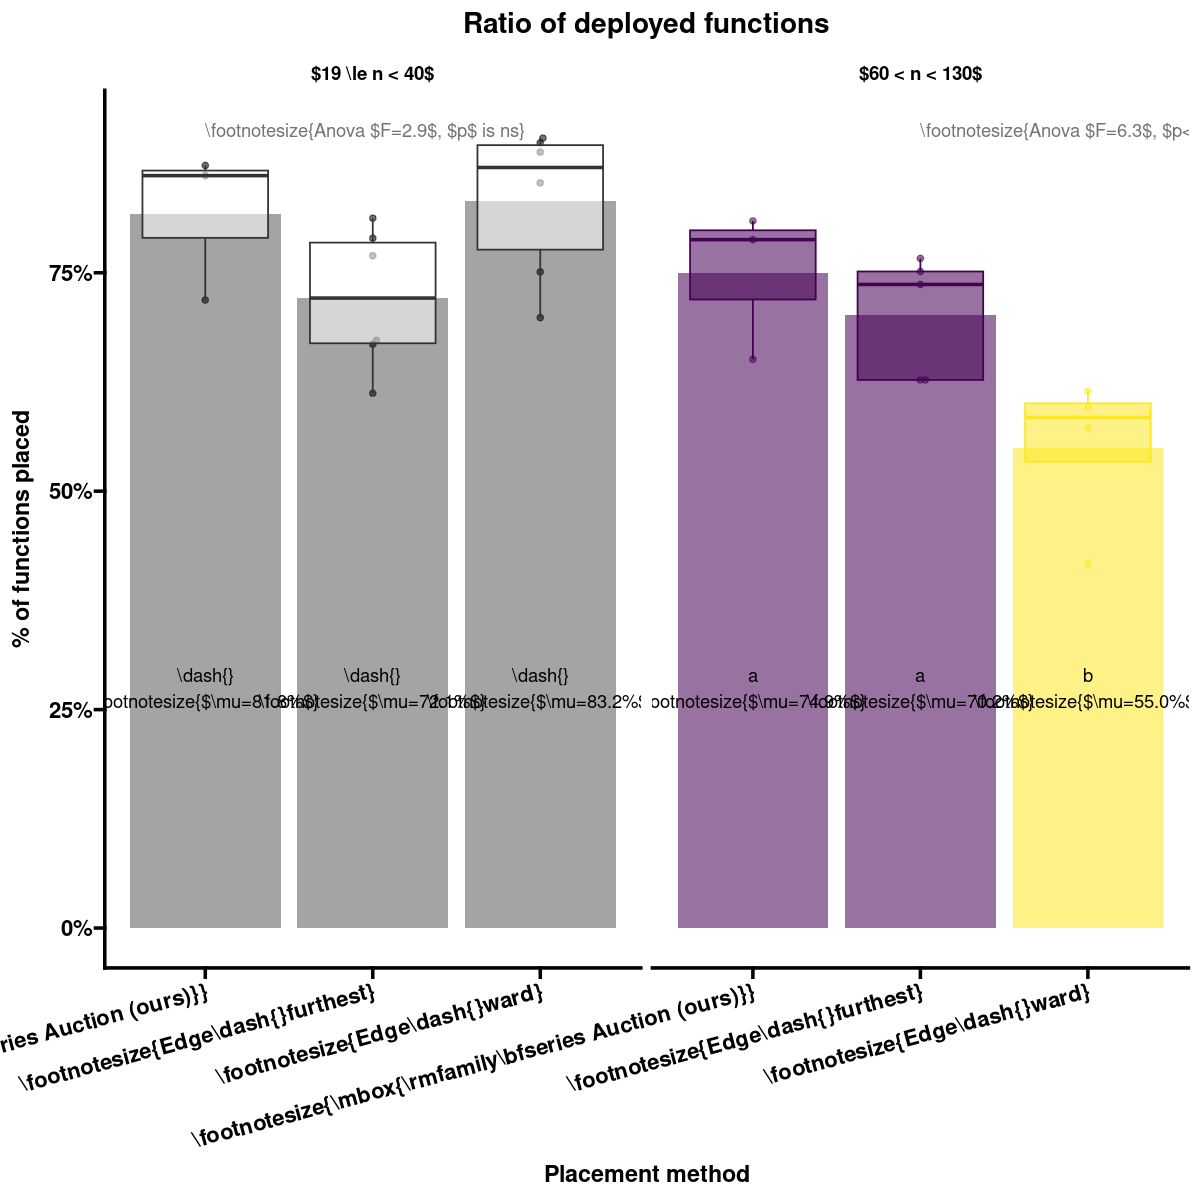

In [1241]:
df <- plots.nb_deployed.data %>% ungroup()
p <- ggplot(data= df, aes(alpha=1)) +  
    facet_grid(cols = vars(var_facet)) +
     labs(
        x = "Placement method",
        y = "Jain's index"
    ) +
   scale_y_continuous(label = scales::percent) +
    scale_alpha_continuous(guide = "none") +
    labs(
        x = "Placement method",
        y = "% of functions placed",
    ) +
    theme( legend.background = element_rect(fill=alpha("white", .7),
                                  size=0.2, color = alpha("white", .7))) +
    theme(legend.spacing.y = unit(0, 'cm'),      legend.margin=margin(0,0,0,0),         legend.box.margin=margin(-10,-10,-10,-10),)+
    theme(axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)) +
    guides(colour = guide_legend(nrow = 1)) +
    theme(legend.position = "none") +
    scale_color_viridis(discrete = T) +
    scale_fill_viridis(discrete = T)

fig(10, 10)

plots.nb_deployed.h <- GRAPH_ONE_COLUMN_HEIGHT
plots.nb_deployed.w <- GRAPH_ONE_COLUMN_WIDTH
plots.nb_deployed.caption = "Ratio of deployed functions"
mean_cb <- function(Letters, mean){
    return(sprintf("%s\n\\footnotesize{$\\mu=%.1f%%$}",Letters, mean*100))
}
plots.nb_deployed <- anova_boxplot(p, df , "Placement method", "nb_functions", "nb_nodes_group", mean_cb)
plots.nb_deployed + labs(title = plots.nb_deployed.caption)

`summarise()` has grouped output by
'var_facet'. You can override using the
`.groups` argument.
Joining with `by = join_by(class_x)`
Joining with `by = join_by(class_x)`


              Df Sum Sq Mean Sq F value   Pr(>F)    
subdf$class_x  2 0.3469 0.17347   13.02 0.000148 ***
Residuals     24 0.3198 0.01333                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

,class_x,Letters,value_y,var_facet,mean
,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,\footnotesize{\mbox{\rmfamily\bfseries Auction (ours)}},a,0.9002331,toto,0.7760874
2,\footnotesize{Edge\dash{}furthest},a,0.8501208,toto,0.8146914
3,\footnotesize{Edge\dash{}ward},b,0.6384035,toto,0.5682951


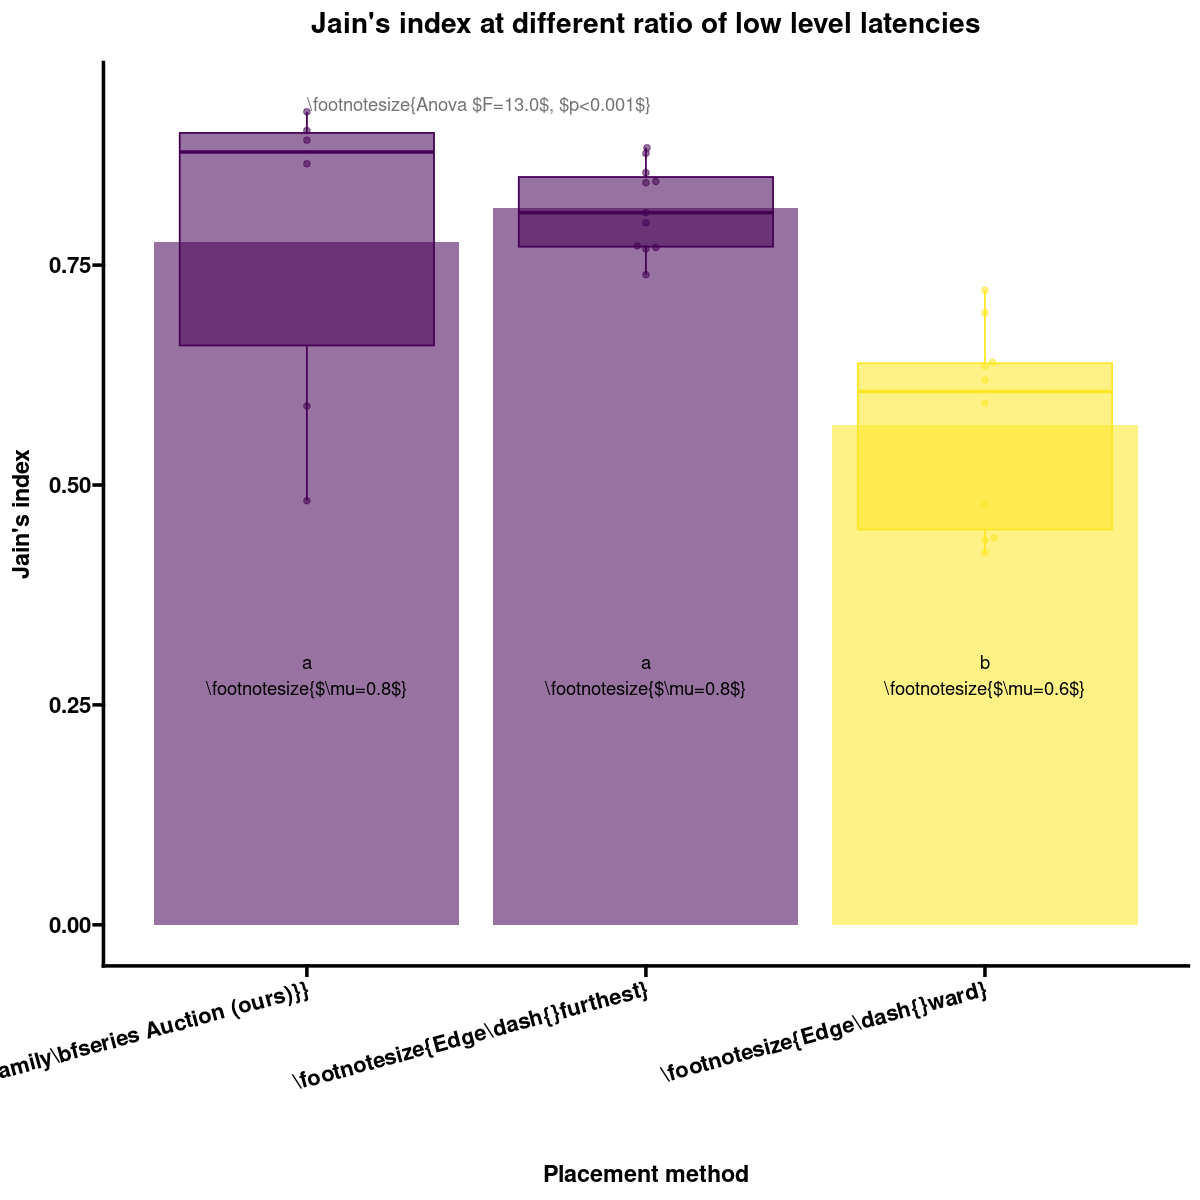

In [1242]:
df <- earnings.jains.plot.data.raw %>% mutate(toto = "toto") %>% ungroup()
p <- ggplot(data= df, aes(alpha=1)) +
     labs(
        x = "Placement method",
        y = "Jain's index"
    ) +
    scale_alpha_continuous(guide = "none") +
    guides(color = guide_legend(nrow = 1), shape = guide_legend(nrow = 1), size = guide_legend(nrow = 1)) +
    theme(legend.background = element_rect(
        fill = alpha("white", .7),
        size = 0.2, color = "white"),
        axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)
    ) +
    theme(legend.position = "none") +
    # theme(legend.position = "top", legend.box = "vertical") +
    scale_color_viridis(discrete = T) +
    scale_fill_viridis(discrete = T)+
    theme(legend.spacing.y = unit(0, "cm"), legend.margin = margin(0, 0, 0, 0), legend.box.margin = margin(0, -10, -10, -10), )

fig(10, 10)
plots.jains.w <- GRAPH_ONE_COLUMN_WIDTH
plots.jains.h <- GRAPH_ONE_COLUMN_HEIGHT
plots.jains.caption <- "Jain's index at different ratio of low level latencies"
mean_cb <- function(Letters, mean){
    return(sprintf("%s\n\\footnotesize{$\\mu=%.1f$}",Letters, mean))
}
plots.jains <- anova_boxplot(p, df , "Placement method", "score", "toto", mean_cb)
plots.jains + labs(title = plots.jains.caption)

In [1243]:

# plots.respected_sla.w <- GRAPH_TWO_COLUMN_WIDTH
# plots.respected_sla.h <- GRAPH_ONE_COLUMN_HEIGHT
# plots.respected_sla.caption <- "Mean of ratio of satisfied responses from functions per ratio of deployed low latency functions"
# fig(plots.respected_sla.w, plots.respected_sla.h)

# fig (15, 15)
# plots.respected_sla.raw <- plots.respected_sla.data %>% 
#     # mutate(group = sprintf("%s\n%s\n%s", latency_type, load_type, ratio_func_ll)) %>%
#     group_by(folder, `Placement method`, group) %>%
#     # mutate(satisfied_count = satisfied_count / total) %>%
#     # summarise(satisfied_count = mean(satisfied_count / total)) %>%
#     summarise(satisfied_count = mean(count.satisfied)) %>%
#     # mutate(satisfied_count = alt_satisfied_count / total) %>%
#     # summarise(satisfied_count = mean(alt_satisfied_count / total), measured_latency = mean(measured_latency)) %>%
#     ggplot(aes(alpha=  1, x = `Placement method`, y = satisfied_count, color = `Placement method`)) +
#     facet_grid(cols = vars(group))+
#     stat_summary(fun = mean, geom = "col", mapping = aes(fill =`Placement method`)) +
#     geom_boxplot() +
#     geom_beeswarm() +
#     # stat_anova_test() +
#     # geom_text(data = generate_label_df(tHSD, 'lev'), aes(x = plot.labels, y = V1, label = labels)) +
#     # stat_compare_means(comparisons = my_comparisons, label = "p.signif") +
#     stat_summary(fun = mean, geom = "text", mapping = aes(label=sprintf("\\footnotesize{$\\mu=%.1f%%$}",..y..*100)), position = position_stack(vjust = .5, reverse = T), color = "black") +
#     scale_alpha_continuous(guide = "none") +
#     theme(
#         axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)
#     ) +
#      theme( legend.background = element_rect(fill=alpha("white", .7),
#                                   size=0.2, color = alpha("white", .7))) +
#         theme(legend.spacing.y = unit(0, 'cm'),      legend.margin=margin(0,0,0,0),         legend.box.margin=margin(-10,-10,-10,-10),)+
#         theme(axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)) +
#     theme(legend.position = "top") +
#     scale_color_viridis(discrete = T) +
#     scale_fill_viridis(discrete = T)+
#     scale_y_continuous(labels = scales::percent) +
#     labs(
#         x = "Placement method",
#         y = "Mean of mean of responses under $SLA_{max\\_latency}$")

# plots.respected_sla.raw + labs(title = plots.respected_sla.caption)

`summarise()` has grouped output by
'folder', 'Placement method',
'latency_type', 'load_type'. You can
override using the `.groups` argument.


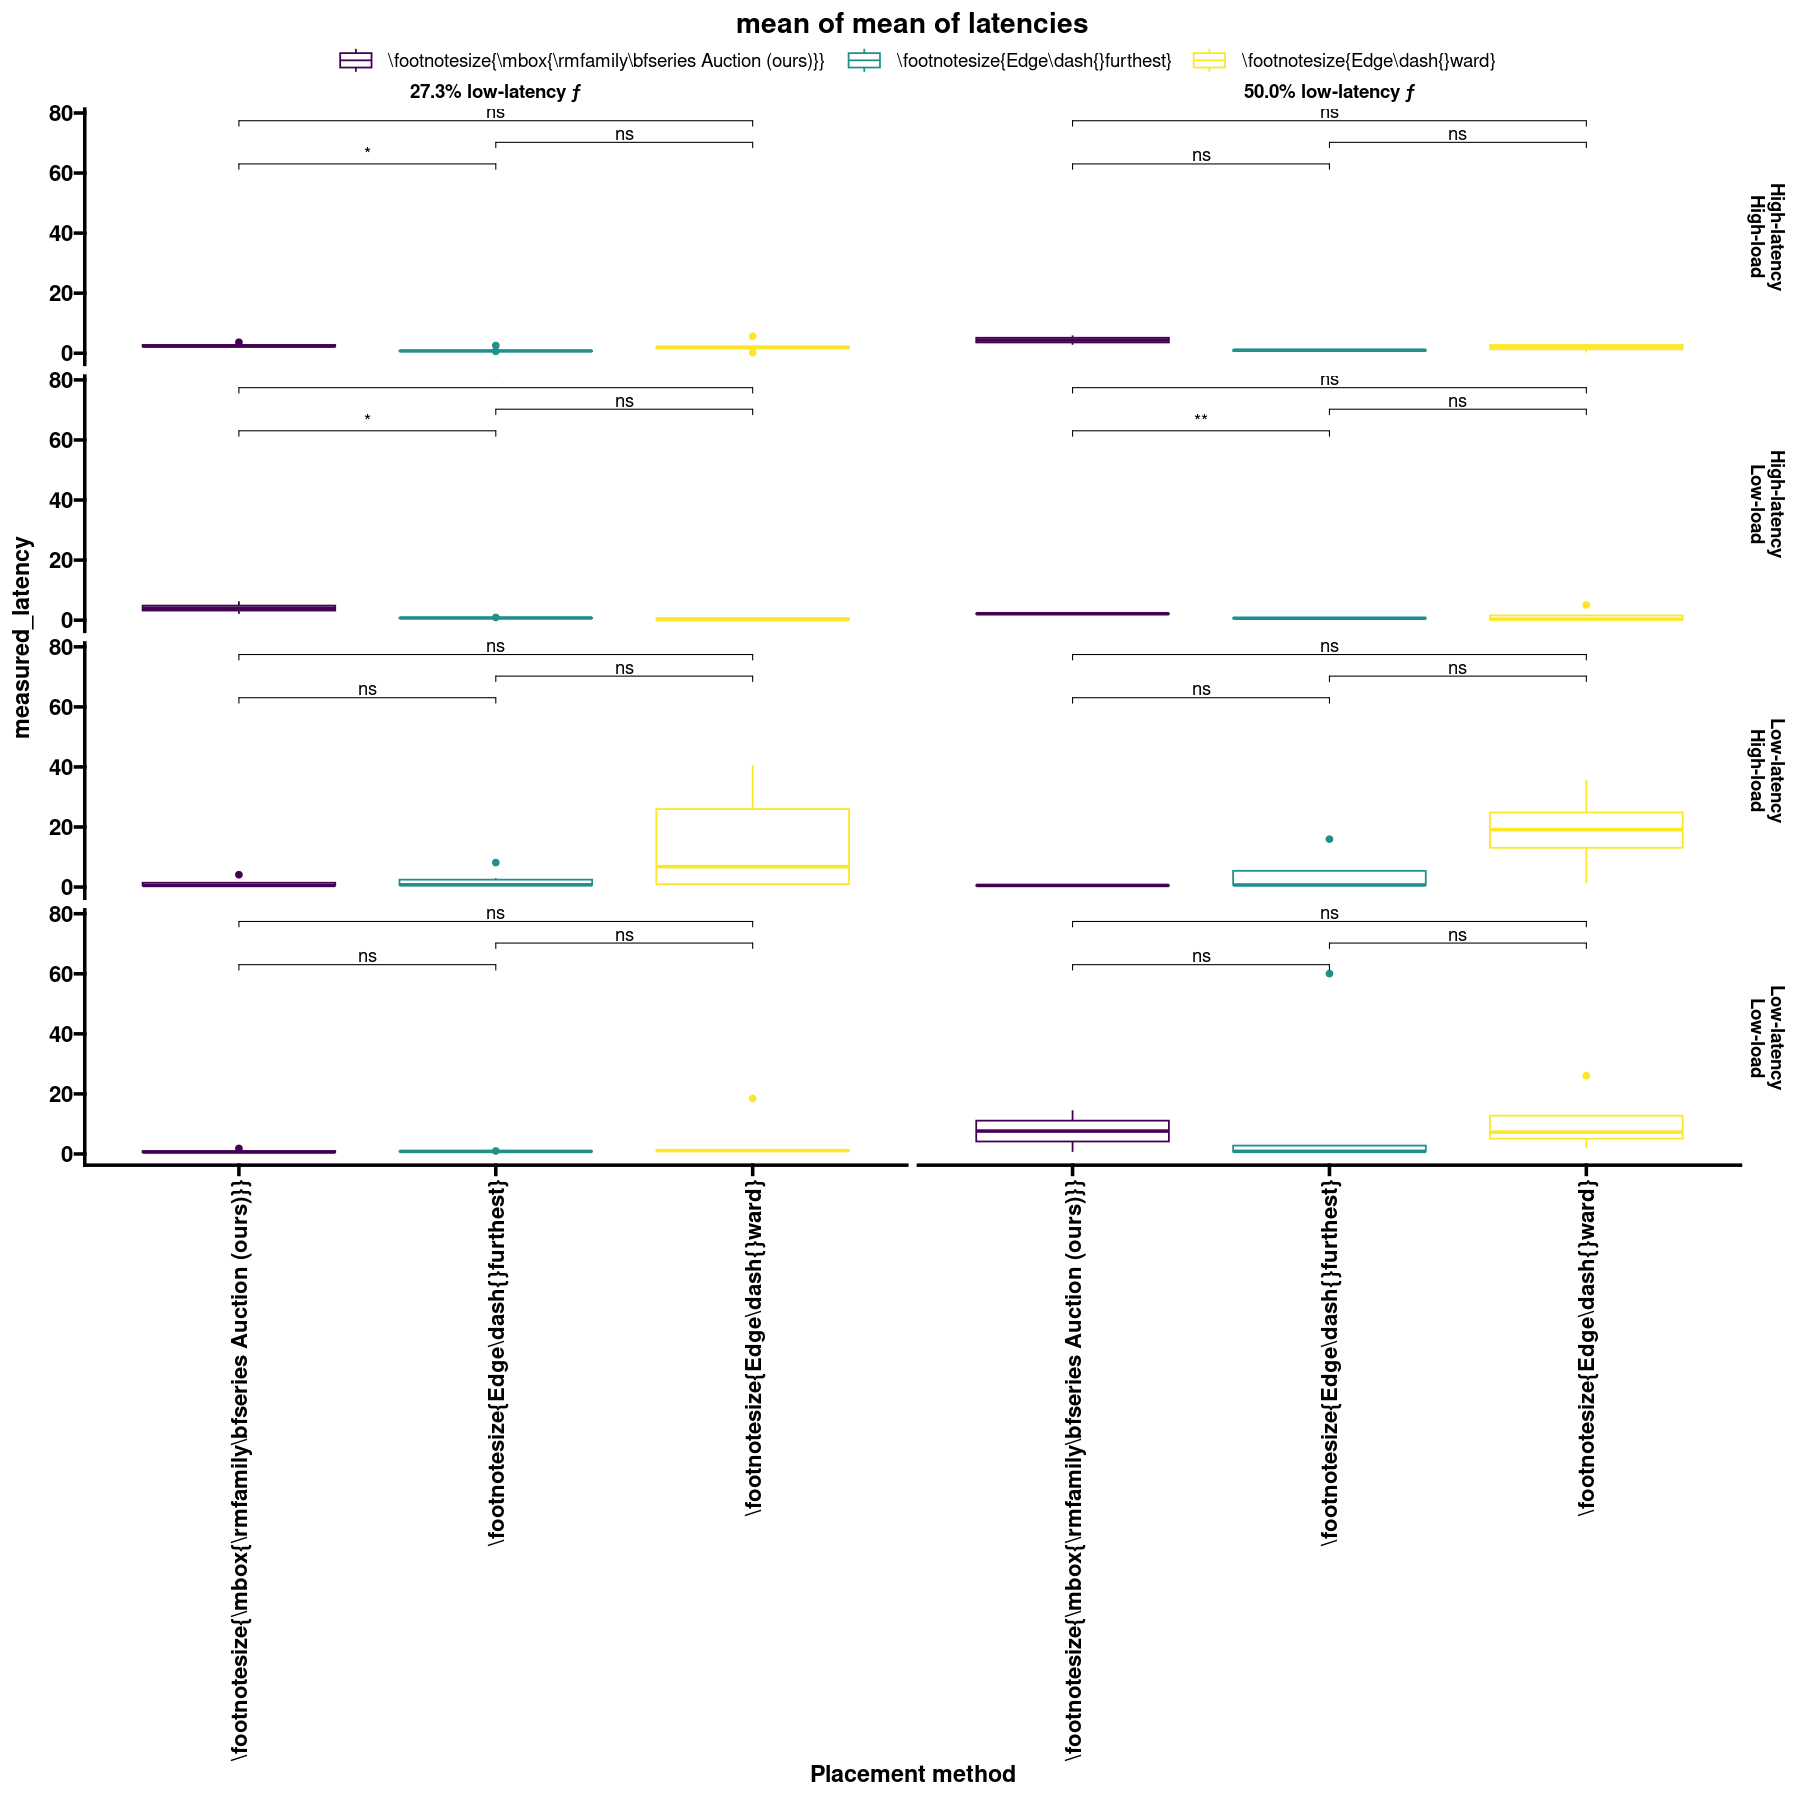

In [1244]:

my_comparisons = combn(unique(plots.respected_sla.data$`Placement method`), 2)
my_comparisons = apply(my_comparisons, 2, list)
my_comparisons <- lapply(my_comparisons, unlist)

fig(15, 15)
plots.respected_sla.data %>% 
    group_by(folder, `Placement method`, latency_type, load_type, ratio_func_ll) %>%
    summarise(measured_latency = mean(measured_latency)) %>%
    ggplot(aes(x = `Placement method`, y = measured_latency, color = `Placement method`)) +
    facet_grid(cols = vars(factor(ratio_func_ll)), rows = vars(sprintf("%s\n%s", latency_type, load_type))) +
    geom_boxplot() +
    # geom_beeswarm() +
    scale_alpha_continuous(guide = "none") +
    stat_compare_means(method = "t.test",  comparisons = my_comparisons, label = "p.signif") +
     theme( legend.background = element_rect(fill=alpha("white", .7),
                                  size=0.2, color = alpha("white", .7))) +
        theme(legend.spacing.y = unit(0, 'cm'),      legend.margin=margin(0,0,0,0),         legend.box.margin=margin(-10,-10,-10,-10),)+
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    theme(legend.position = "top") +
    scale_color_viridis(discrete = T) +
    scale_fill_viridis(discrete = T)+
    labs(title = "mean of mean of latencies")


[1] "...1"                            "result"                         
 [3] "table"                           "_start"                         
 [5] "_stop"                           "timestamp"                      
 [7] "value"                           "field"                          
 [9] "_measurement"                    "bid_id"                         
[11] "function_name"                   "instance"                       
[13] "sla_id"                          "folder"                         
[15] "metric_group"                    "metric_group_group"             
[17] "docker_fn_name"                  "function_index"                 
[19] "latency"                         "cpu"                            
[21] "mem"                             "load_type"                      
[23] "latency_type"                    "nb_fn_low_interval_low_latency" 
[25] "nb_fn_high_interval_low_latency"

Joining with `by = join_by(folder,
metric_group)`


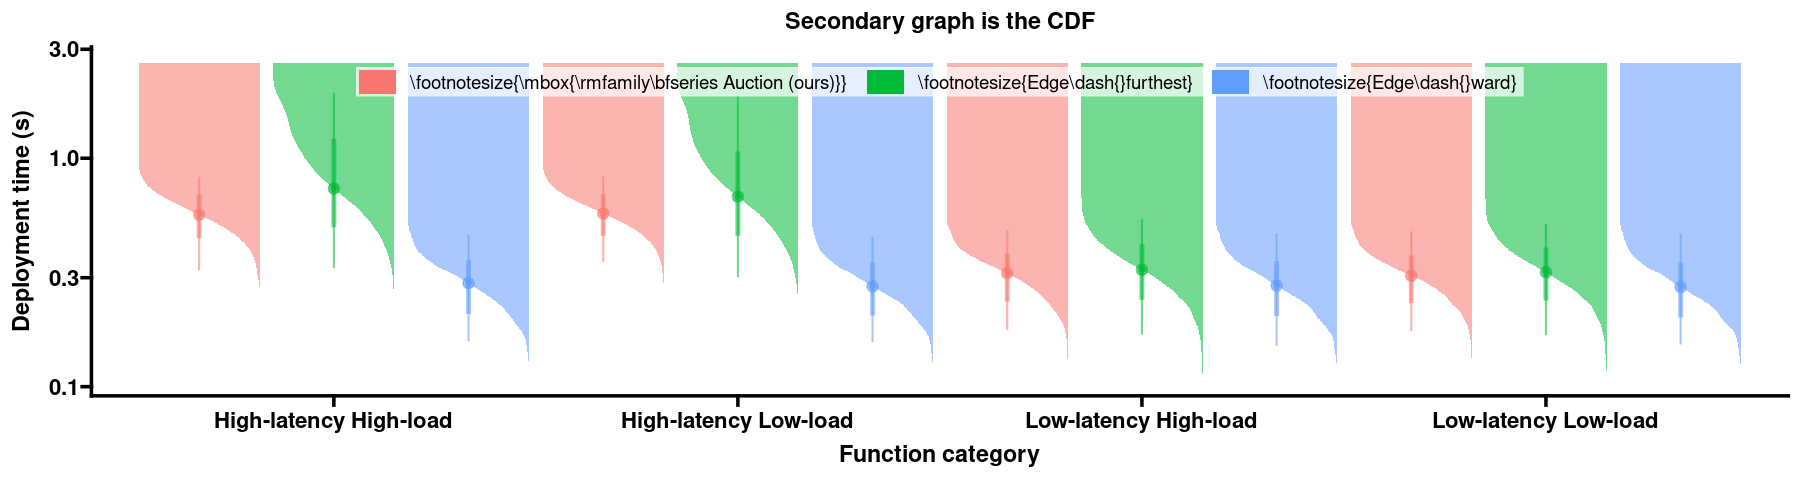

In [1245]:
# colnames(earnings.jain)

center_reduction <- function(data, colvar) {
    colvar <- rlang::sym(colvar)
    data %>%
        inner_join(data %>% summarise(mean = mean(!!colvar), sd = sd(!!colvar))) %>%
        mutate(!!colvar := (!!colvar - mean)/sd) %>%
        select(-c("sd", "mean"))
}

colnames(raw.deployment_times)

raw.deployment_times.plot.data <- raw.deployment_times %>%
    inner_join(raw.function_low_latency_load_category) %>%
    mutate(fn_category = sprintf("%s %s", latency_type, load_type)) %>%
    mutate(value = value / 1000)

plots.deployment_times.w = 15
plots.deployment_times.h = 4
plots.deployment_times.caption = "Deployment times per function category"
fig(plots.deployment_times.w, plots.deployment_times.h)

plots.deployment_times <- raw.deployment_times.plot.data %>% 
    correct_names() %>%
    ggplot(aes(alpha=0, x = factor(fn_category), y = value, group = `Placement method`, color = `Placement method`, fill = `Placement method`)) +
    stat_cdfinterval(position = "dodge") +
    scale_y_continuous(trans = "log10") +
    scale_alpha_continuous(guide = "none") +
    labs(subtitle = "Secondary graph is the CDF",
    x = "Function category",
    y = "Deployment time (s)"
    ) +
    theme( legend.background = element_rect(fill=alpha("white", .7),
                                  size=0.2, color = alpha("white", .7))) +
        theme(legend.spacing.y = unit(0, 'cm'),      legend.margin=margin(0,0,0,0),         legend.box.margin=margin(-10,-10,-10,-10),)+
    theme(legend.position = c(.5, .90)) +
    guides(colour = guide_legend(nrow = 1))

plots.deployment_times    

In [1246]:
colnames(raw.deployment_times.plot.data)

slice_sample(raw.deployment_times.plot.data %>% select(instance, everything()), n = 5)

[1] "...1"                            "result"                         
 [3] "table"                           "_start"                         
 [5] "_stop"                           "timestamp"                      
 [7] "value"                           "field"                          
 [9] "_measurement"                    "bid_id"                         
[11] "function_name"                   "instance"                       
[13] "sla_id"                          "folder"                         
[15] "metric_group"                    "metric_group_group"             
[17] "docker_fn_name"                  "function_index"                 
[19] "latency"                         "cpu"                            
[21] "mem"                             "load_type"                      
[23] "latency_type"                    "nb_fn_low_interval_low_latency" 
[25] "nb_fn_high_interval_low_latency" "category"                       
[27] "requests"                        "fn_category"

instance,...1,result,table,_start,_stop,timestamp,value,field,_measurement,⋯,latency,cpu,mem,load_type,latency_type,nb_fn_low_interval_low_latency,nb_fn_high_interval_low_latency,category,requests,fn_category
<chr>,<lgl>,<lgl>,<dbl>,<dttm>,<dttm>,<dttm>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
marketplace,NA,NA,429,1970-01-01,2023-09-22 23:30:34,2023-09-22 23:29:59,0.723,value,function_deployment_duration,⋯,0.105,400,400,High-load,High-latency,40,40,0.25,5760,High-latency High-load
marketplace,NA,NA,299,1970-01-01,2023-09-22 22:54:05,2023-09-22 22:42:29,0.182,value,function_deployment_duration,⋯,0.011,200,200,Low-load,Low-latency,40,40,0.25,1760,Low-latency Low-load
marketplace,NA,NA,2066,1970-01-01,2023-09-23 01:18:42,2023-09-23 00:52:29,1.092,value,function_deployment_duration,⋯,0.100,400,400,High-load,High-latency,40,40,0.25,5760,High-latency High-load
marketplace,NA,NA,1175,1970-01-01,2023-09-22 22:45:42,2023-09-22 22:17:35,0.312,value,function_deployment_duration,⋯,0.010,400,400,High-load,Low-latency,40,40,0.25,2240,Low-latency High-load
marketplace,NA,NA,555,1970-01-01,2023-09-22 22:54:05,2023-09-22 22:35:29,0.250,value,function_deployment_duration,⋯,0.100,200,200,Low-load,High-latency,40,40,0.25,1760,High-latency Low-load


`summarise()` has grouped output by
'folder', 'metric_group'. You can override
using the `.groups` argument.


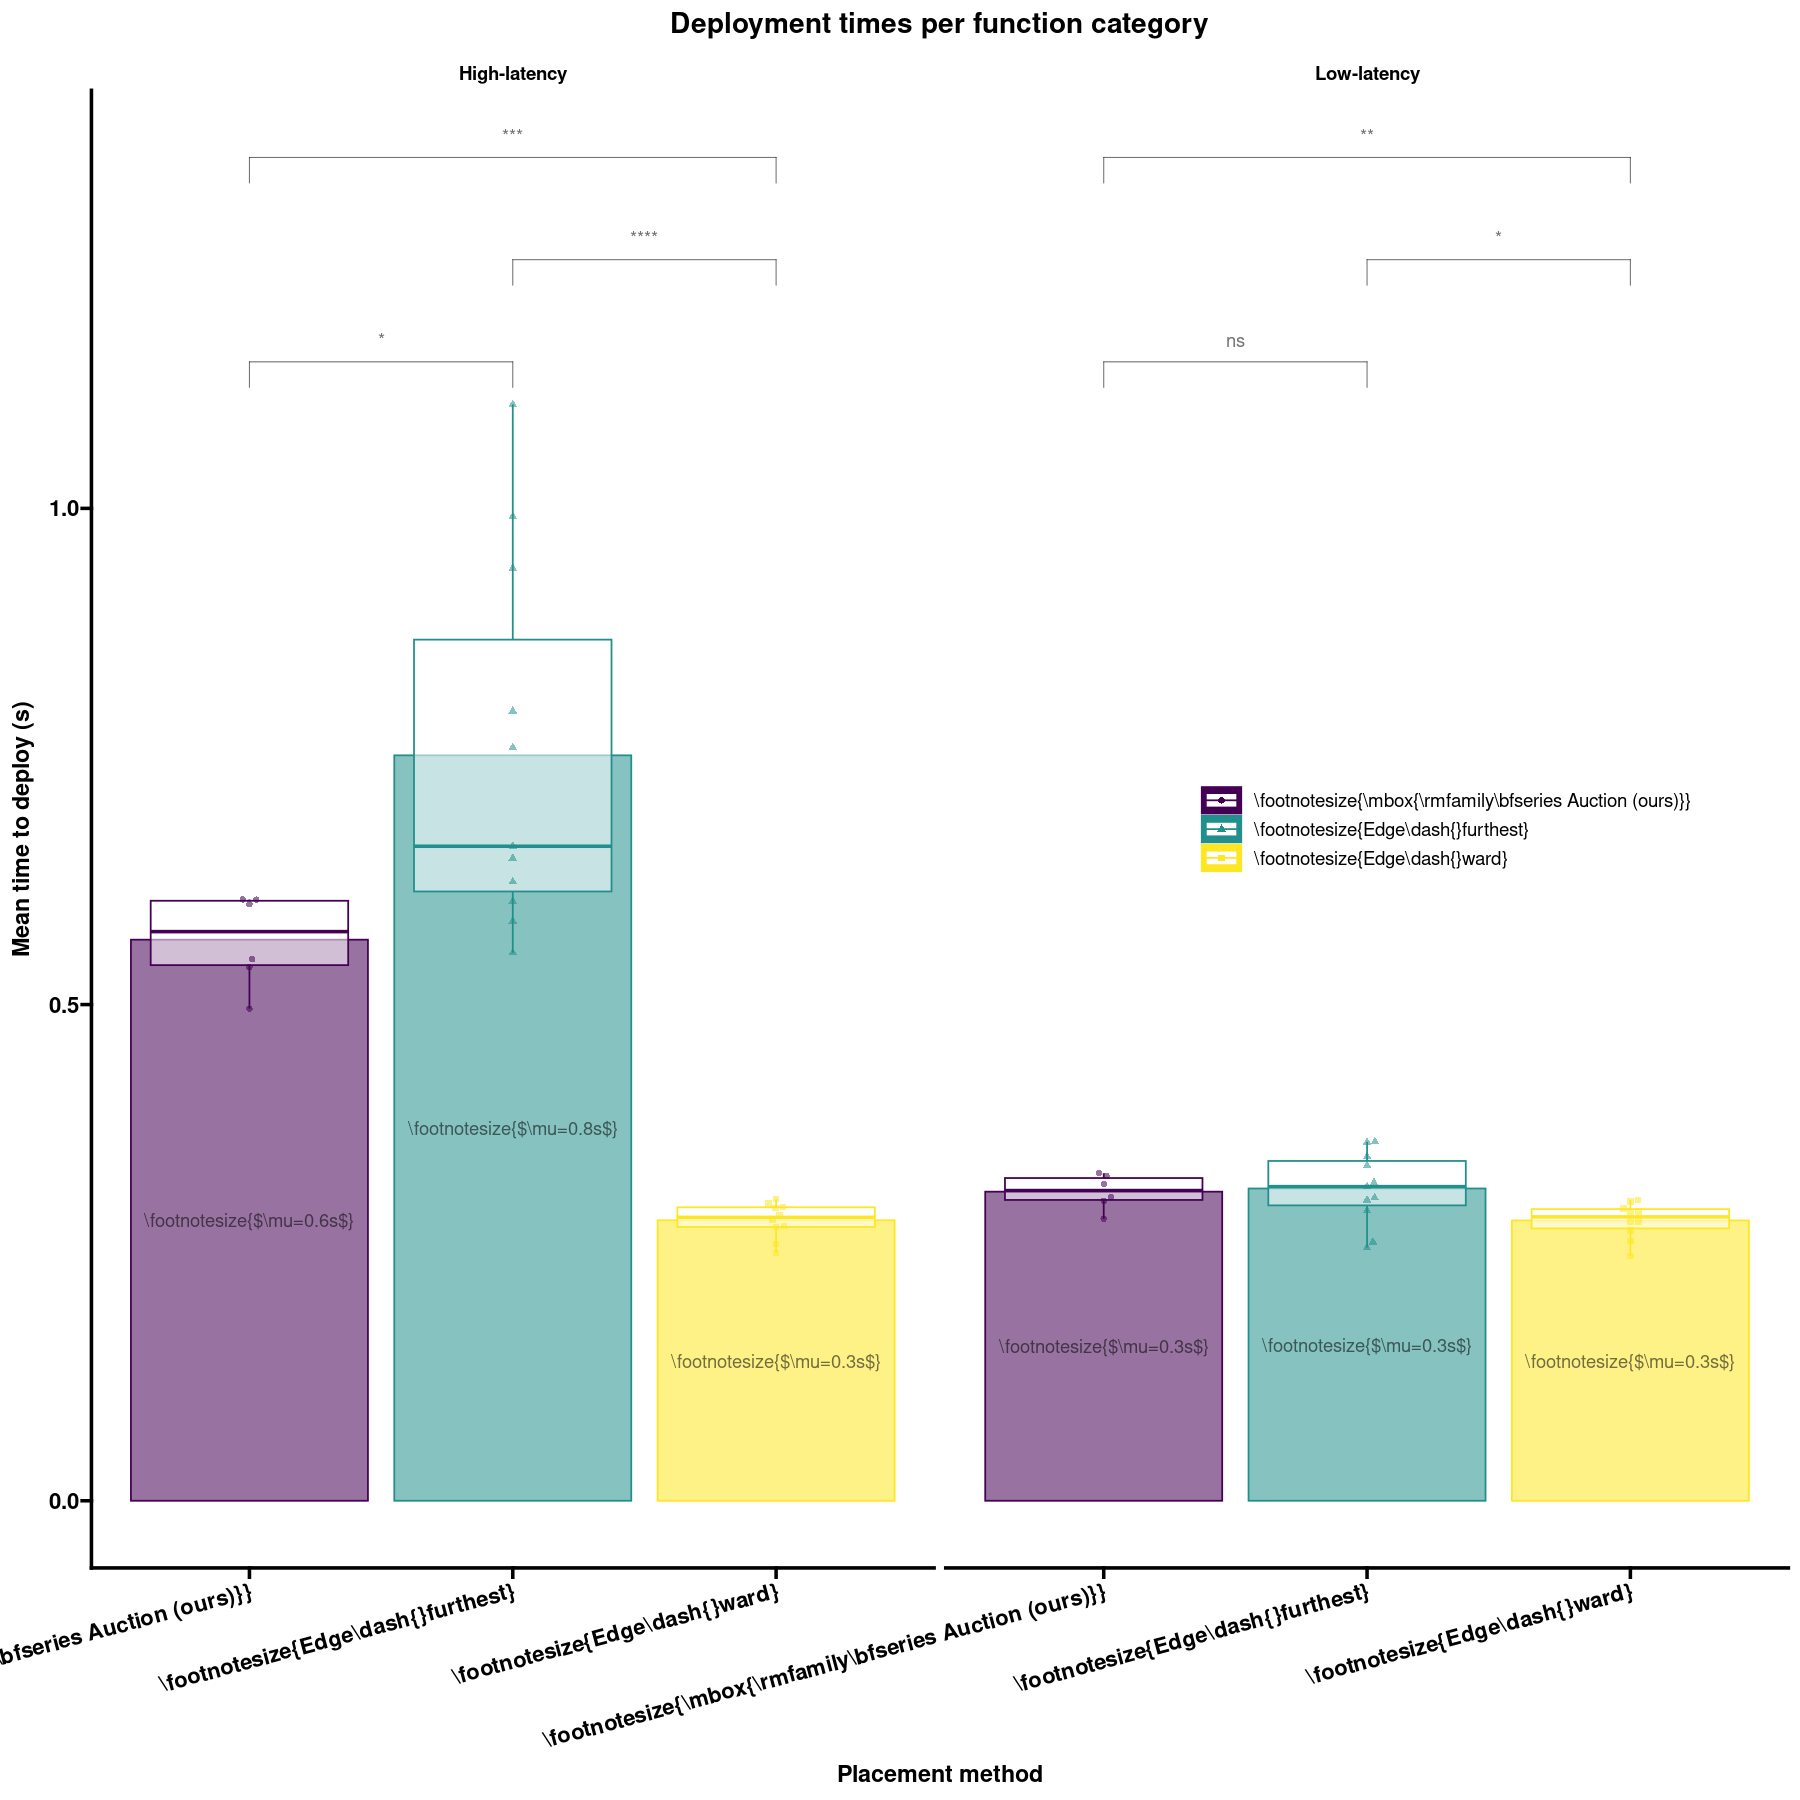

In [1247]:
plots.deploymenttimes.w <- GRAPH_ONE_COLUMN_WIDTH
plots.deploymenttimes.h <- 5
plots.deploymenttimes.caption = "Time to find a fog node for a function"
fig(plots.deploymenttimes.w, plots.deploymenttimes.h)
fig(15, 15)
my_comparisons = combn(unique(plots.respected_sla.data$`Placement method`), 2)
my_comparisons = apply(my_comparisons, 2, list)
my_comparisons <- lapply(my_comparisons, unlist)

plots.deploymenttimes.raw <- raw.deployment_times.plot.data %>% 
    group_by(folder, metric_group, latency_type) %>%
    summarise(value = mean(value)) %>%
    correct_names() %>%
    ggplot(aes(alpha=0, y = value, x = `Placement method`, color = `Placement method`, shape = `Placement method`)) +
    stat_summary(fun = mean, geom = "col", mapping = aes(fill =`Placement method`)) +
    geom_boxplot() +
    geom_beeswarm() +
    stat_compare_means(comparisons = my_comparisons, label = "p.signif") +
    stat_summary(fun = mean, geom = "text", mapping = aes(label=sprintf("\\footnotesize{$\\mu=%.1fs$}",..y..)), position = position_stack(vjust = .5, reverse = T), color = "black") +
    scale_alpha_continuous(guide = "none") +
    labs(
    y = "Mean time to deploy (s)",
    x = "Placement method",
    ) +
       theme( legend.background = element_rect(fill=alpha("white", .7),
                                  size=0.2, color = alpha("white", .7)),
        axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)

                                  ) +
        theme(legend.spacing.y = unit(0, 'cm'),      legend.margin=margin(0,0,0,0),         legend.box.margin=margin(-10,-10,-10,-10),)+
    theme(legend.position = c(.8, .5)) +
    guides(colour = guide_legend(ncol = 1)) +
    scale_color_viridis(discrete = T) +
    scale_fill_viridis(discrete = T)+
    facet_wrap(vars(latency_type))

plots.deploymenttimes.raw + labs(title = plots.deployment_times.caption)

`summarise()` has grouped output by
'folder', 'metric_group'. You can override
using the `.groups` argument.
`summarise()` has grouped output by
'var_facet'. You can override using the
`.groups` argument.
Joining with `by = join_by(class_x)`
Joining with `by = join_by(class_x)`


              Df Sum Sq Mean Sq F value   Pr(>F)    
subdf$class_x  2 1.1562  0.5781   38.72 3.08e-08 ***
Residuals     24 0.3584  0.0149                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

,class_x,Letters,value_y,var_facet,mean
,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,\footnotesize{\mbox{\rmfamily\bfseries Auction (ours)}},c,0.6045946,High-latency,0.5653722
2,\footnotesize{Edge\dash{}furthest},a,0.8677186,High-latency,0.7511389
3,\footnotesize{Edge\dash{}ward},b,0.2957480,High-latency,0.2826462


Joining with `by = join_by(class_x)`
Joining with `by = join_by(class_x)`


              Df   Sum Sq   Mean Sq F value Pr(>F)  
subdf$class_x  2 0.006117 0.0030587   4.165  0.028 *
Residuals     24 0.017627 0.0007345                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

,class_x,Letters,value_y,var_facet,mean
,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,\footnotesize{\mbox{\rmfamily\bfseries Auction (ours)}},ab,0.3252001,Low-latency,0.3114554
2,\footnotesize{Edge\dash{}furthest},a,0.3424071,Low-latency,0.3146681
3,\footnotesize{Edge\dash{}ward},b,0.2938815,Low-latency,0.2824664


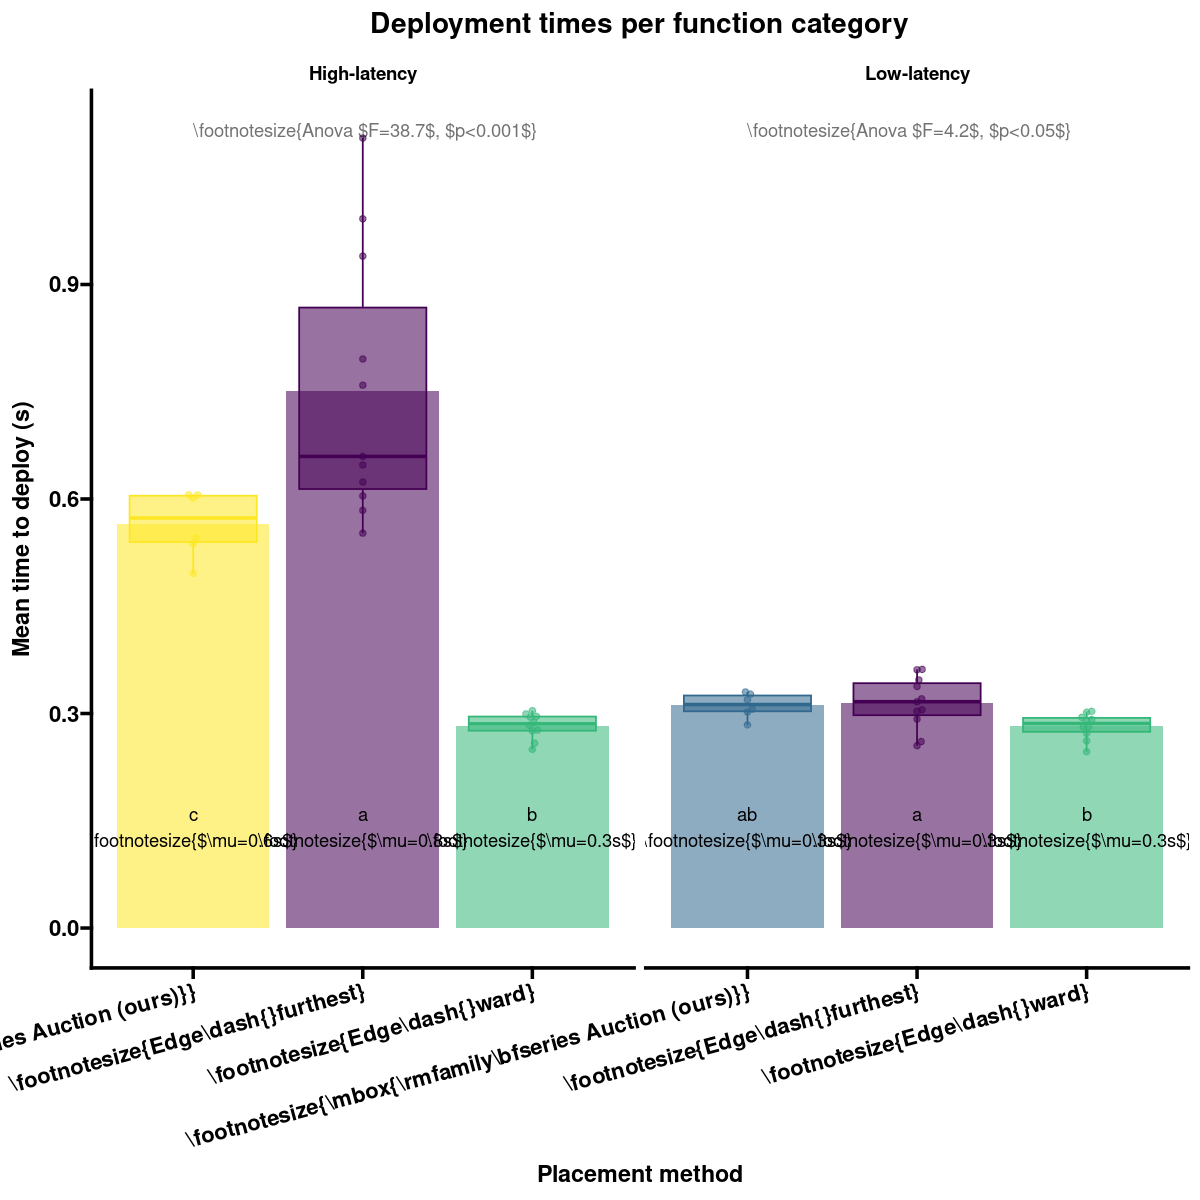

In [1248]:
df <- raw.deployment_times.plot.data %>% 
    group_by(folder, metric_group, latency_type) %>%
    summarise(value = mean(value)) %>%
    correct_names() %>% 
    mutate(group = "sdlkfjh") %>%
    ungroup()

p <- ggplot(data= df, aes(alpha=1)) +  
     facet_grid(~var_facet) +
     theme(legend.position="none") +scale_alpha_continuous(guide = "none") +
    labs(
    y = "Mean time to deploy (s)",
    x = "Placement method",
    ) +
       theme( legend.background = element_rect(fill=alpha("white", .7),
                                  size=0.2, color = alpha("white", .7)),
        axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)

                                  ) +
        theme(legend.spacing.y = unit(0, 'cm'),      legend.margin=margin(0,0,0,0),         legend.box.margin=margin(-10,-10,-10,-10),)+
    # theme(legend.position = c(.8, .5)) +
    guides(colour = guide_legend(ncol = 1)) +
    scale_color_viridis(discrete = T) +
    scale_fill_viridis(discrete = T)
fig(10, 10)
plots.deploymenttimes.w <- GRAPH_ONE_COLUMN_WIDTH
plots.deploymenttimes.h <- GRAPH_ONE_COLUMN_HEIGHT
plots.deploymenttimes.caption = "Time to find a fog node for a function"
mean_cb <- function(Letters, mean){
    return(sprintf("%s\n\\footnotesize{$\\mu=%.1fs$}",Letters, mean))
}
plots.deploymenttimes <- anova_boxplot(p, df , "Placement method", "value", "latency_type", mean_cb)
plots.deploymenttimes + labs(title = plots.deployment_times.caption)

In [1249]:
# plots.skew.data <- bids_won_function %>% 
#     extract_function_name_info() %>%
#     left_join(raw.nb_functions.total.full %>% rename(total_func = total)) %>%
#     left_join(raw.nb_functions.total.ll %>% rename(total_func_ll = total)) %>%
#     mutate(ratio_func_ll = total_func_ll / total_func) %>%
#     mutate(ratio_func_ll = sprintf("%.1f%% ll ƒ", ratio_func_ll *100)) %>% 
#     group_by(folder, metric_group, load_type, latency_type) %>%
#     summarise(spending = (mean(cost) - median(cost)) / sd(cost)) %>%
#     mutate(fn_category = sprintf("%s\n%s", latency_type, load_type)) %>%
#     correct_names()

# my_comparisons = combn(unique(plots.skew.data$`Placement method`), 2)
# my_comparisons = apply(my_comparisons, 2, list)
# my_comparisons <- lapply(my_comparisons, unlist)

# plots.skew.caption <- "Nonparametric skew of a client's spending by function type"
# plots.skew.w <- GRAPH_TWO_COLUMN_WIDTH
# plots.skew.h <- GRAPH_ONE_COLUMN_HEIGHT

# fig(plots.skew.w, plots.skew.h)

# plots.skew <- plots.skew.data %>%
#     # summarySE("cost", c("metric_group", "requests", "fn_category", "level_value"), conf.interval = .95) %>%
#     # correct_names() %>%
#     ggplot(aes(alpha=0, x = `Placement method`, y = spending, shape = `Placement method`, color = `Placement method`, fill = `Placement method`)) +
#     # facet_grid(cols = vars(ratio_func_ll), rows= vars(fn_category), scales = "free")+
#     facet_grid(cols = vars(fn_category))+
#     geom_boxplot()+
#     geom_beeswarm()+
#     stat_compare_means(comparisons = my_comparisons, label = "p.signif") +
#     # geom_hline(yintercept=1) +
#     scale_alpha_continuous(guide = "none") +
#     labs(
#         subtitle = "A positive skew indicates a tendency of\nthe spending distribution to be on the high side",
#         y = "Skew",
#         x = "Placement method",
#     ) +
#     theme( legend.background = element_rect(fill=alpha("white", .7),
#                                 size=0.2, color = alpha("white", .7))) +
#     theme(legend.spacing.y = unit(0, 'cm'),
#         legend.margin=margin(0,0,0,0), 
#         legend.box.margin=margin(-10,-10,-10,-10),
#         axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)
#         )+
#     # scale_x_discrete(guide = guide_axis(n.dodge = 2)) +
#     # theme(legend.position = c(.5, .93)) +
#     theme(legend.position = "top") +
#     scale_color_viridis(discrete = T) +
#     scale_fill_viridis(discrete = T)+
#     guides(colour = guide_legend(nrow = 1))
    

# plots.skew + labs(title = plots.skew.caption)

Joining with `by = join_by(folder)`
Joining with `by = join_by(folder)`
`summarise()` has grouped output by
'folder', 'metric_group', 'load_type'. You
can override using the `.groups` argument.
`summarise()` has grouped output by
'fn_category'. You can override using the
`.groups` argument.


fn_category,metric_group,spending
<chr>,<ord>,<dbl>
High-latency High-load,edge_ward,0.3963114
High-latency High-load,edge_first_v2,0.6367970
High-latency High-load,auction,0.2888636
High-latency Low-load,edge_ward,0.2678378
High-latency Low-load,edge_first_v2,0.3459617
High-latency Low-load,auction,0.1370963
Low-latency High-load,edge_ward,0.4087639
Low-latency High-load,edge_first_v2,0.5783396
Low-latency High-load,auction,0.6624289


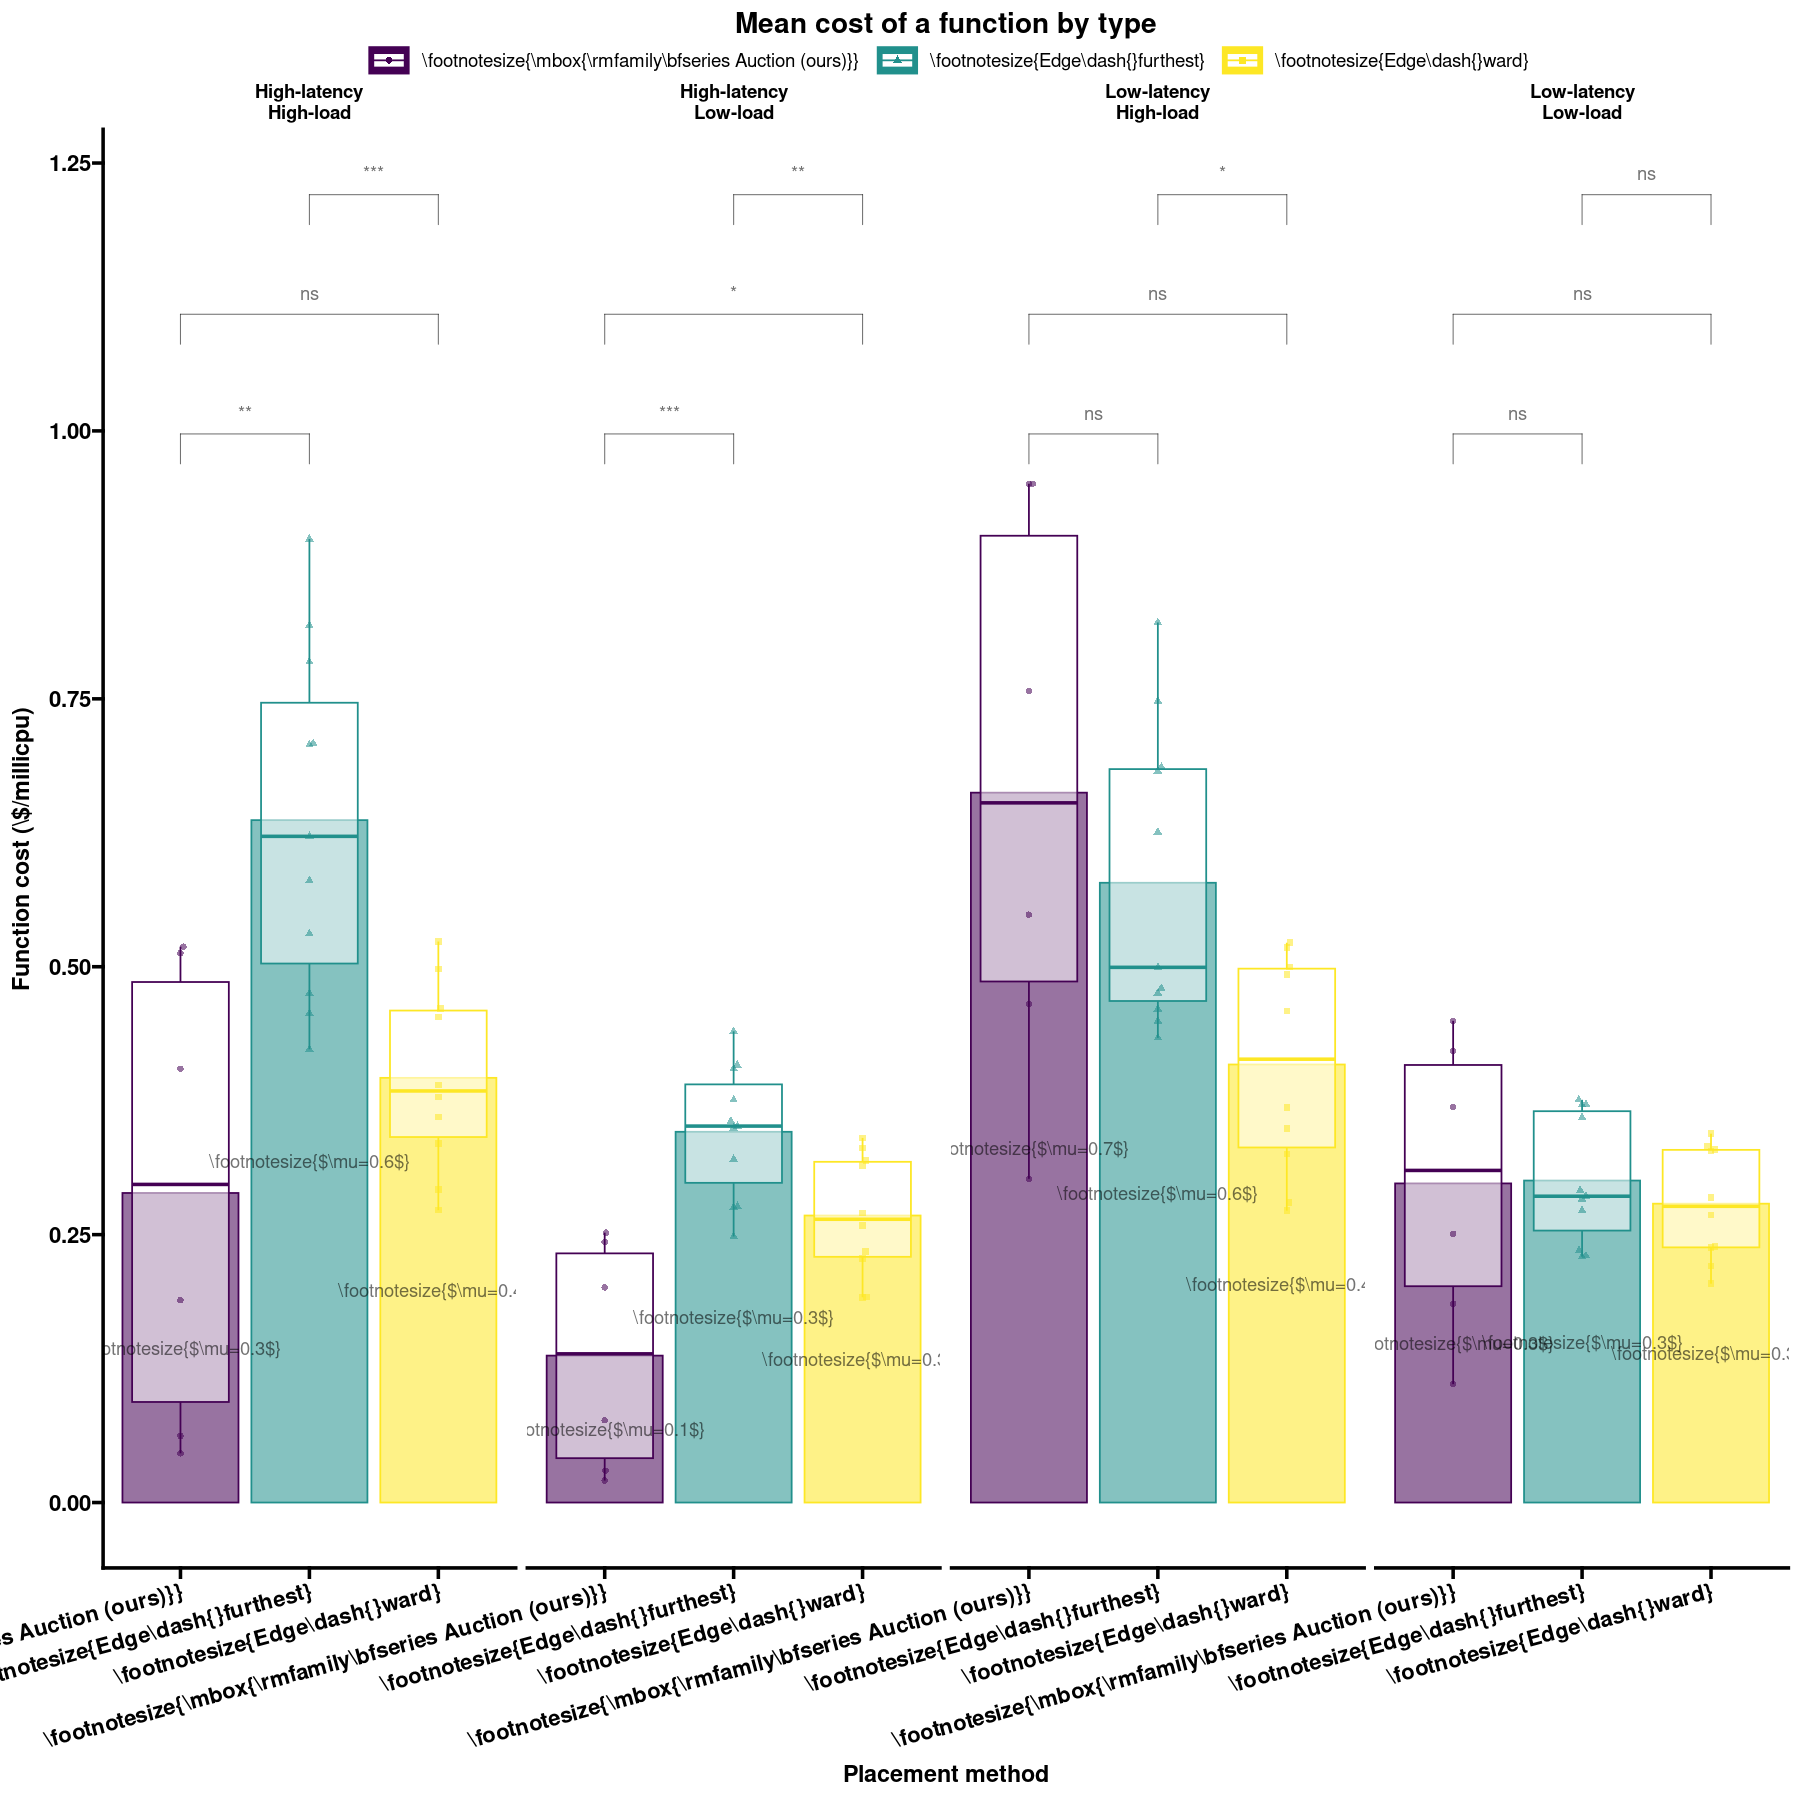

In [1250]:
plots.spending.data <- bids_won_function %>% 
    extract_function_name_info() %>%
    left_join(raw.nb_functions.total.full %>% rename(total_func = total)) %>%
    left_join(raw.nb_functions.total.ll %>% rename(total_func_ll = total)) %>%
    mutate(ratio_func_ll = total_func_ll / total_func) %>%
    mutate(ratio_func_ll = sprintf("%.1f%% ll ƒ", ratio_func_ll *100)) %>% 
    group_by(folder, metric_group, load_type, latency_type) %>%
    summarise(spending = mean(cost)) %>%
    mutate(fn_category = sprintf("%s\n%s", latency_type, load_type)) %>%
    correct_names()

plots.spending.data %>% 
    group_by(fn_category, metric_group) %>% 
    summarise(spending = mean(spending))

my_comparisons = combn(unique(plots.spending.data$`Placement method`), 2)
my_comparisons = apply(my_comparisons, 2, list)
my_comparisons <- lapply(my_comparisons, unlist)

plots.spending.caption <- "Mean cost of a function by type"
plots.spending.w <- GRAPH_TWO_COLUMN_WIDTH
plots.spending.h <- GRAPH_ONE_COLUMN_HEIGHT

fig(plots.spending.w, plots.spending.h)
fig(15, 15)
plots.spending.raw <- plots.spending.data %>%
    # summarySE("cost", c("metric_group", "requests", "fn_category", "level_value"), conf.interval = .95) %>%
    # correct_names() %>%
    ggplot(aes(alpha=0, x = `Placement method`, y = spending, shape = `Placement method`, color = `Placement method`)) +
    # facet_grid(cols = vars(ratio_func_ll), rows= vars(fn_category), scales = "free")+
    facet_grid(cols=vars(fn_category))+
    stat_summary(fun = mean, geom = "col", mapping = aes(fill =`Placement method`)) +
    geom_boxplot()+
    geom_beeswarm()+
    stat_compare_means(comparisons = my_comparisons, label = "p.signif") +
    stat_summary(fun = mean, geom = "text", mapping = aes(label=sprintf("\\footnotesize{$\\mu=%.1f$}",..y..)), position = position_stack(vjust = .5, reverse = T), color = "black") +
    # geom_hline(yintercept=1) +
    scale_alpha_continuous(guide = "none") +
    labs(
        y = "Function cost (\\$/millicpu)",
        x = "Placement method",
    ) +
    theme( legend.background = element_rect(fill=alpha("white", .7),
                                size=0.2, color = alpha("white", .7))) +
    theme(legend.spacing.y = unit(0, 'cm'),
        legend.margin=margin(0,0,0,0), 
        legend.box.margin=margin(-10,-10,-10,-10),
        axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)
        )+
    # scale_x_discrete(guide = guide_axis(n.dodge = 2)) +
    # theme(legend.position = c(.5, .93)) +
    theme(legend.position = "top") +
    scale_color_viridis(discrete = T) +
    scale_fill_viridis(discrete = T)+
    guides(colour = guide_legend(nrow = 1))
    

plots.spending.raw + labs(title = plots.spending.caption)

`summarise()` has grouped output by
'var_facet'. You can override using the
`.groups` argument.
Joining with `by = join_by(class_x)`
Joining with `by = join_by(class_x)`


              Df Sum Sq Mean Sq F value   Pr(>F)    
subdf$class_x  2 0.5572 0.27860   12.05 0.000238 ***
Residuals     24 0.5550 0.02313                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

,class_x,Letters,value_y,var_facet,mean
,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,\footnotesize{\mbox{\rmfamily\bfseries Auction (ours)}},b,0.4857376,High-latency High-load,0.2888636
2,\footnotesize{Edge\dash{}furthest},a,0.7463438,High-latency High-load,0.6367970
3,\footnotesize{Edge\dash{}ward},b,0.4590992,High-latency High-load,0.3963114


Joining with `by = join_by(class_x)`
Joining with `by = join_by(class_x)`


              Df Sum Sq Mean Sq F value Pr(>F)  
subdf$class_x  2 0.2774 0.13871   5.225 0.0131 *
Residuals     24 0.6372 0.02655                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

,class_x,Letters,value_y,var_facet,mean
,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,\footnotesize{\mbox{\rmfamily\bfseries Auction (ours)}},b,0.9021861,Low-latency High-load,0.6624289
2,\footnotesize{Edge\dash{}furthest},ab,0.6844197,Low-latency High-load,0.5783396
3,\footnotesize{Edge\dash{}ward},a,0.4982052,Low-latency High-load,0.4087639


Joining with `by = join_by(class_x)`
Joining with `by = join_by(class_x)`


              Df Sum Sq Mean Sq F value   Pr(>F)    
subdf$class_x  2 0.1695 0.08474   16.55 3.04e-05 ***
Residuals     24 0.1229 0.00512                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

,class_x,Letters,value_y,var_facet,mean
,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,\footnotesize{\mbox{\rmfamily\bfseries Auction (ours)}},c,0.2325077,High-latency Low-load,0.1370963
2,\footnotesize{Edge\dash{}furthest},a,0.3902073,High-latency Low-load,0.3459617
3,\footnotesize{Edge\dash{}ward},b,0.3179538,High-latency Low-load,0.2678378


Joining with `by = join_by(class_x)`
Joining with `by = join_by(class_x)`


              Df  Sum Sq  Mean Sq F value Pr(>F)
subdf$class_x  2 0.00271 0.001354   0.213   0.81
Residuals     24 0.15260 0.006358               

,class_x,Letters,value_y,var_facet,mean
,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,\footnotesize{\mbox{\rmfamily\bfseries Auction (ours)}},a,0.4083131,Low-latency Low-load,0.2977928
2,\footnotesize{Edge\dash{}furthest},a,0.3651865,Low-latency Low-load,0.3004606
3,\footnotesize{Edge\dash{}ward},a,0.3291012,Low-latency Low-load,0.2788864


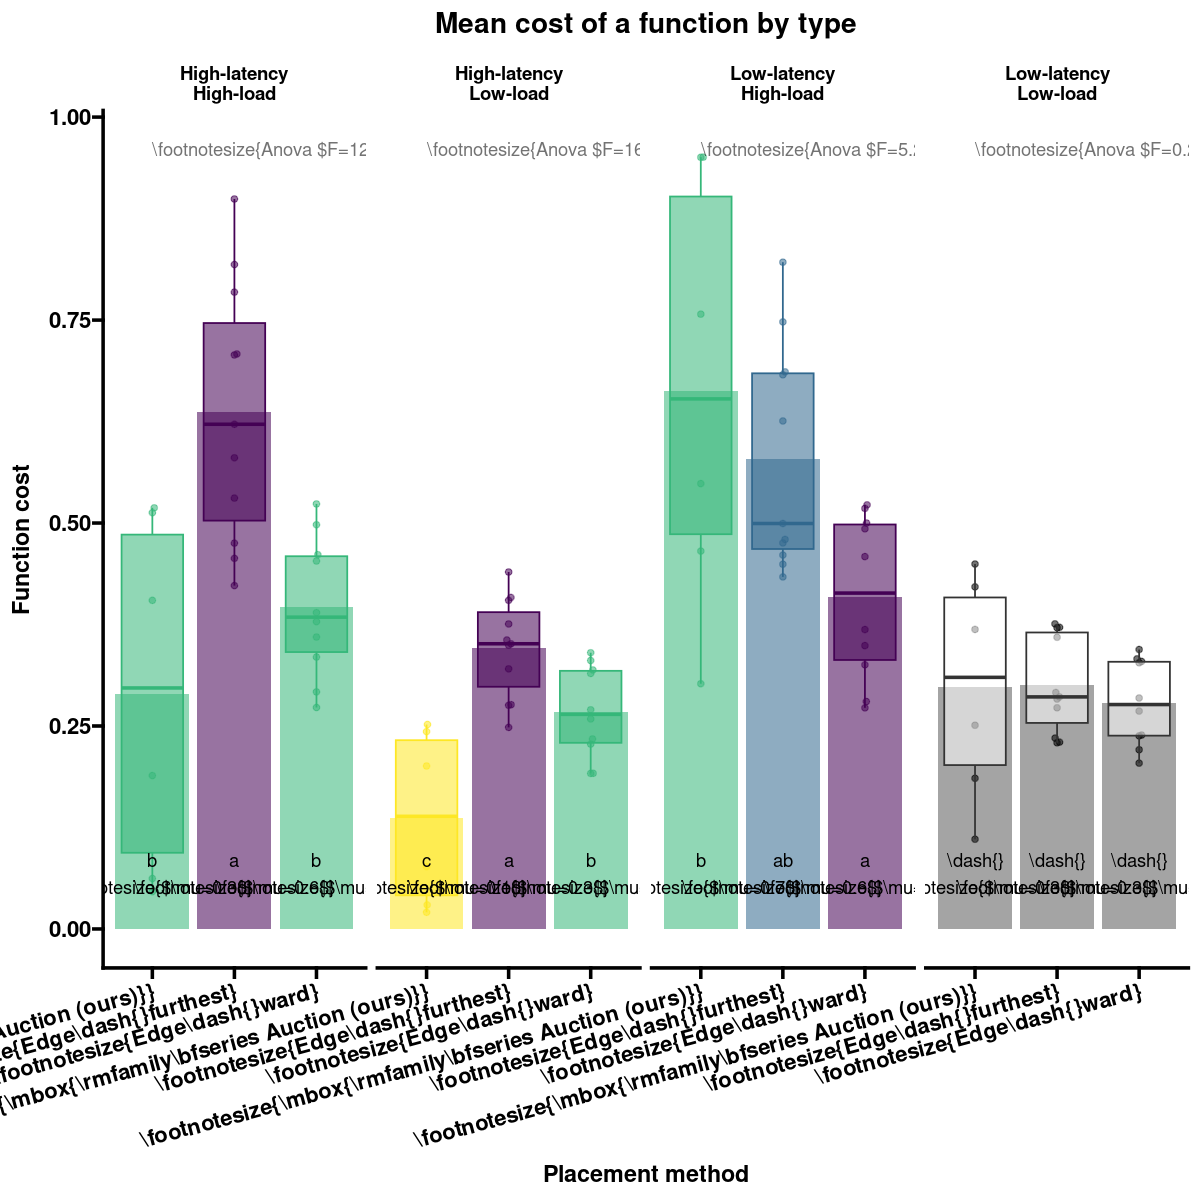

In [1251]:
df <- plots.spending.data %>% 
    ungroup()

p <- ggplot(data= df, aes(alpha=1)) +  
     facet_grid(~var_facet) +
     theme(legend.position="none") +
     scale_alpha_continuous(guide = "none") +
    labs(
        y = "Function cost",
        x = "Placement method",
    ) +
    theme( legend.background = element_rect(fill=alpha("white", .7),
                                size=0.2, color = alpha("white", .7))) +
    theme(legend.spacing.y = unit(0, 'cm'),
        legend.margin=margin(0,0,0,0), 
        legend.box.margin=margin(-10,-10,-10,-10),
        axis.text.x = element_text(angle = 15, vjust = 1, hjust=1)
        )+
    # scale_x_discrete(guide = guide_axis(n.dodge = 2)) +
    # theme(legend.position = c(.5, .93)) +
    scale_color_viridis(discrete = T) +
    scale_fill_viridis(discrete = T)+
    guides(colour = guide_legend(nrow = 1))

fig(10, 10)
mean_cb <- function(Letters, mean){
    return(sprintf("%s\n\\footnotesize{$\\mu=%.1f$}",Letters, mean))
}
plots.spending <- anova_boxplot(p, df , "Placement method", "spending", "fn_category", mean_cb)
plots.spending + labs(title = plots.spending.caption)

In [1252]:
plots.nb_functions.data <- load_csv("provisioned_functions.csv") %>%
    prepare() %>%
    extract_function_name_info() %>%
    group_by(folder, latency_type, load_type) %>%
    summarise(provisioned = sum(value)) %>%
    inner_join(raw.nb_functions.total %>% rename(target = total)) %>%
    inner_join(raw.function_low_latency_load_category) %>%
    mutate(ratio_deployed = provisioned / target) %>%
    mutate(fn_category = sprintf("%s %s", latency_type, load_type)) 

New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`


New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
`summarise()` has grouped output by
'folder', 'latency_type'. You can override
using the `.groups` argument.
Joining with `by = join_by(folder,
latency_type, load_type)`
Joining with `by = join_by(folder,
metric_group)`


In [1253]:
slice_sample(plots.nb_functions.data %>% ungroup(), n= 5)

folder,latency_type,load_type,provisioned,metric_group_group,metric_group,target,category,requests,ratio_deployed,fn_category
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>


In [1254]:
# fig(7, 7)
# colnames(node_levels)
# plots.nb_functions.line.data <- load_csv("provisioned_functions.csv") %>%
#     prepare() %>%
#     extract_function_name_info() %>%
#     inner_join(bids_won_function) %>%
#     group_by(folder, latency_type, load_type, winner) %>%
#     summarise(provisioned = sum(value)) %>%
#     inner_join(raw.nb_functions.total %>% rename(target = total))  %>%
#     inner_join(raw.function_low_latency_load_category) %>%
#     left_join(node_levels %>% rename(winner = name)) %>%
#     mutate(ratio_deployed = provisioned / target) %>%
#     mutate(fn_category = sprintf("%s %s", latency_type, load_type)) %>%
#     summarySE("ratio_deployed", c("metric_group", "fn_category", "level_value"))

In [1255]:
plots.nb_functions.data = load_csv("provisioned_functions.csv") %>%
    prepare() %>%
    extract_function_name_info() %>%
    inner_join(bids_won_function) %>%
    group_by(folder, latency_type, load_type, winner) %>%
    summarise(provisioned = sum(value)) %>%
    inner_join(raw.nb_functions.total %>% rename(target = total))  %>%
    inner_join(raw.function_low_latency_load_category) %>%
    left_join(node_levels %>% rename(winner = name)) %>%
    mutate(ratio_deployed = provisioned / target) %>%
    mutate(fn_category = sprintf("%s\n%s", latency_type, load_type))

New names:
• `` -> `...1`


New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
New names:
• `` -> `...1`
Joining with `by = join_by(function_name,
sla_id, folder, metric_group,
metric_group_group)`
`summarise()` has grouped output by
'folder', 'latency_type', 'load_type'. You
can override using the `.groups` argument.
Joining with `by = join_by(folder,
latency_type, load_type)`
Joining with `by = join_by(folder,
metric_group)

In [1256]:
colnames(plots.nb_functions.data)

plots.nb_functions.data.processed = plots.nb_functions.data %>%
    group_by(folder, metric_group, level_value, target) %>%
    summarise(provisioned = sum(provisioned)) %>%
    mutate(ratio_deployed = provisioned / target)

slice_sample(plots.nb_functions.data.processed %>% ungroup(), n = 5)

[1] "folder"             "latency_type"       "load_type"         
 [4] "winner"             "provisioned"        "metric_group_group"
 [7] "metric_group"       "target"             "category"          
[10] "requests"           "level_value"        "level"             
[13] "ratio_deployed"     "fn_category"

`summarise()` has grouped output by
'folder', 'metric_group', 'level_value'.
You can override using the `.groups`
argument.


folder,metric_group,level_value,target,provisioned,ratio_deployed
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>


In [1257]:
escape_latex_special_chars <- function(text) {
  # Define special characters to escape
  special_chars <- c("%", "&", "#", "_", "\\$", "\\{", "\\}", "\\^", "\\~")

  # Escape each special character with a backslash
  for (char in special_chars) {
    text <- gsub(char, paste0("\\", substring(char, nchar(char), nchar(char))), text, fixed = TRUE)
  }

  return(text)
}


tibble_to_latex_tabular <- function(data, file) {
  cat("\\begin{tabular}{", paste0(rep("c", ncol(data)), collapse = " "), "}\n", file = file)
  cat("\\hline\n", file = file, append = TRUE)

  # Print column names with escaped special characters
  cat(paste0(escape_latex_special_chars(colnames(data)), collapse = " & "), " \\\\\n", file = file, append = TRUE)
  cat("\\hline\n", file = file, append = TRUE)

  # Print rows with escaped special characters
  for (i in 1:nrow(data)) {
    cat(paste0(escape_latex_special_chars(as.character(data[i, ])), collapse = " & "), " \\\\\n", file = file, append = TRUE)
  }

  cat("\\hline\n", file = file, append = TRUE)
  cat("\\end{tabular}", file = file, append = TRUE)
}



Active compiler:
	/nix/store/mxi2rv8ywa8yh9njv4wjirkfsvy9k0wd-texlive-combined-full-2022-final/bin/xelatex
	XeTeX 3.141592653-2.6-0.999994 (Web2C 2022/nixos.org)
	kpathsea version 6.3.4



Measuring dimensions of: A

Running command: '/nix/store/mxi2rv8ywa8yh9njv4wjirkfsvy9k0wd-texlive-combined-full-2022-final/bin/xelatex' -interaction=batchmode -halt-on-error -output-directory '/tmp/nix-shell.ckf88K/RtmpKw4zCL/tikzDevice1ccc761750d8ec' 'tikzStringWidthCalc.tex'



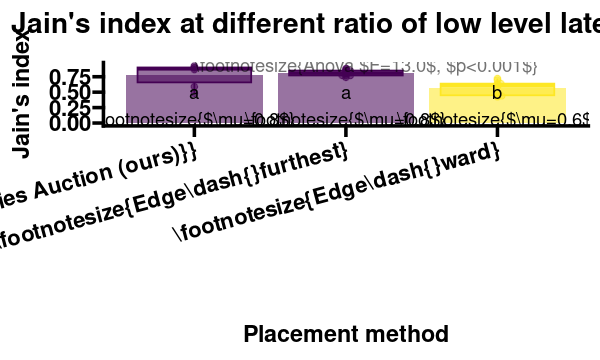

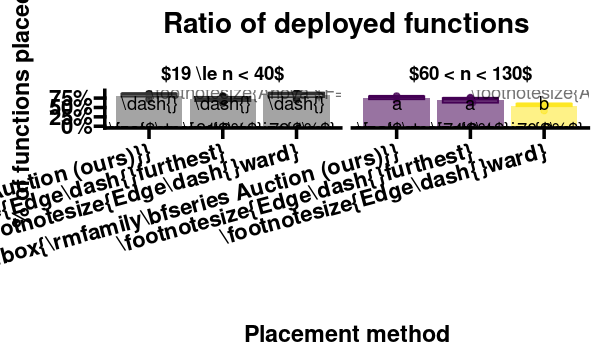

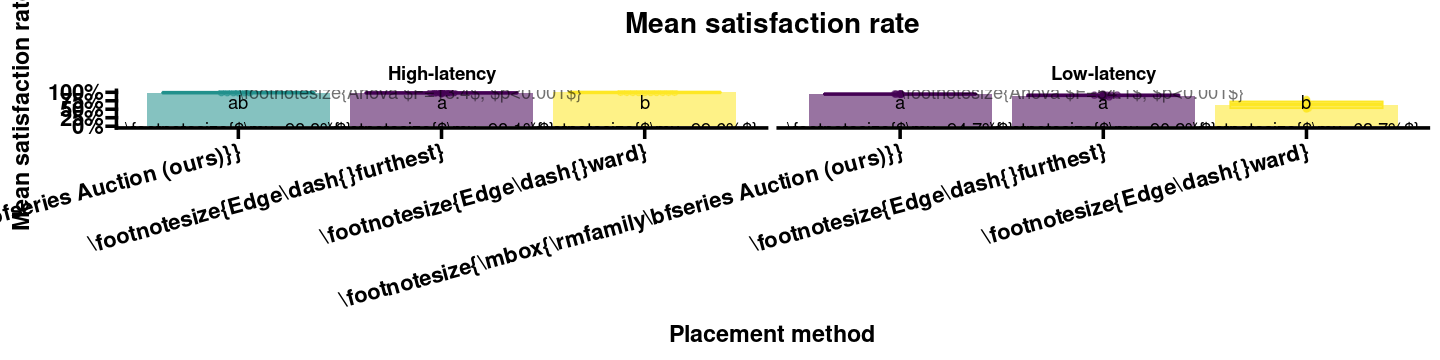

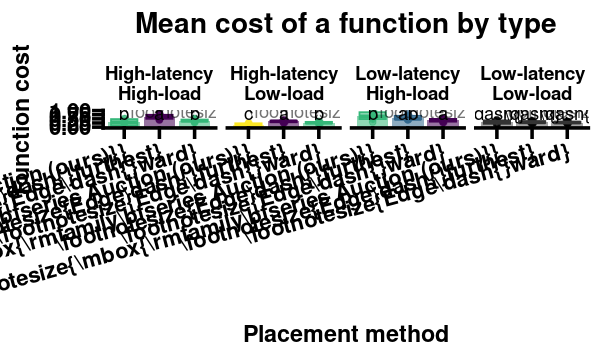

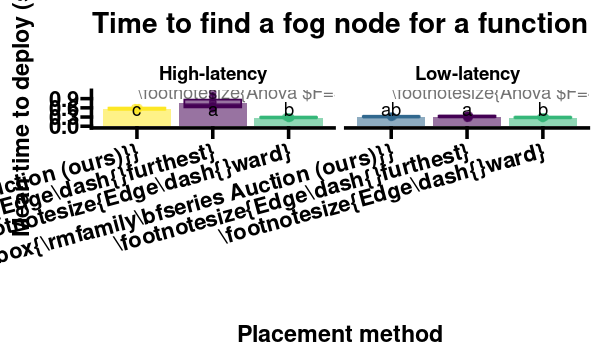

In [1258]:
if (length(find.package("tikzDevice", quiet = TRUE))) {
    library(tikzDevice)
    options(tikzDefaultEngine = "xetex")
    options(
        tikzSanitizeCharacters = c("%", "&", "#", "\\$", "\\{", "\\}", "\\^", "\\~", "ƒ"),
        tikzReplacementCharacters = c("\\%", "\\&", "\\#", "\\\\$", "\\\\{", "\\\\}", "\\\\^", "\\\\~", "$f$")
    )
    options(tikzXelatexPackages = c(
        "\\usepackage{tikz}\n",
        "\\usepackage[active,tightpage,xetex]{preview}\n",
        "\\usepackage{fontspec,xunicode}\n",
        "\\PreviewEnvironment{pgfpicture}\n",
        "\\setlength\\PreviewBorder{0pt}\n",
        "\\newcommand{\\dash}{-}\n"
    ))
    options(
        tikzMetricPackages = c(
        "\\usepackage[T1]{fontenc}\n",
        "\\usetikzlibrary{calc}\n"
        ),
        tikzUnicodeMetricPackages = c(
        "\\usepackage[T1]{fontenc}\n",
        "\\usetikzlibrary{calc}\n",
        "\\usepackage{fontspec,xunicode}\n"
        )
        )
    # options(tikzMetricPackages = c("\\usepackage{preview}", "\\usepackage{pgf}", "\\usepackage{xcolor}"))

    tikzDevice::tikzTest()

    column_width = 7

    export_graph <- function(name, plot, width, height, caption) {
        tikzDevice::tikz(name, width = width, height = height, standAlone = FALSE, sanitize = TRUE) # , standAlone = TRUE)
        print(plot)
        dev.off()

        # read the existing content of the file
        existing_content <- readLines(name)

        tex_width = 1
        if (width > GRAPH_ONE_COLUMN_WIDTH) {
           tex_width = 2
        }

        new_content <- c( 
            sprintf("\\newcommand{\\dash}{-}\n\\resizebox{%s\\columnwidth}{!}{", tex_width),
            existing_content,
            "}",
            sprintf("\\caption{%s}", caption)
            )

        # write the new content to the file
        writeLines(new_content, name)

        fig(width, height)
        print(plot + labs (title = caption))

    }


    # tikzDevice::tikz("./nodes.tex", width = 15, height = 5, standAlone = FALSE, sanitize = TRUE) # , standAlone = TRUE)
    # plot(net_connected, layout = coords, asp = 0.22, margin = -0, edge.label = E(net_connected)$weight, edge.width = 1, vertex.size = 5, vertex.label.cex = 1, vertex.dist = 20, edge.arrow.size = 0.5, edge.label.cex = 0.8, edge.label.dist = 1.5)
    # dev.off()

    export_graph("./jain.tex", plots.jains, plots.jains.w, plots.jains.h, plots.jains.caption)
    export_graph("./nb_deployed.tex", plots.nb_deployed, plots.nb_deployed.w, plots.nb_deployed.h, plots.nb_deployed.caption)
    export_graph("./respected_sla.tex", plots.respected_sla, plots.respected_sla.w, plots.respected_sla.h, plots.respected_sla.caption)
    # export_graph("./skew.tex", plots.skew, plots.skew.w, plots.skew.h, plots.skew.caption)
    export_graph("./spending.tex", plots.spending, plots.spending.w, plots.spending.h, plots.spending.caption)
    export_graph("./deploymenttimes.tex", plots.deploymenttimes, plots.deploymenttimes.w, plots.deploymenttimes.h, plots.deploymenttimes.caption)

    # output_file <- "nb_experiences_per_categories.tex"
    # tibble_to_latex_tabular(nb_experiences_per_categories, output_file)
}

